# Typical Sets: What They Are and How to (Hopefully) Find Them

This is a companion notebook to a talk given at the 2017 Astrostat Day Sep. 20, 2017 at the CfA. It contains several the plots used in the talk and the code used to generate them as well as the general outline. A basic working knowledge of Bayesian statistics and Markov Chain Monte Carlo (MCMC) is recommended to get the most out of this notebook.

In [1]:
# Python 3 compatability
from __future__ import division, print_function
from six.moves import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np

# plotting
import matplotlib
from matplotlib import pyplot as plt

# inline plotting
%matplotlib inline

# seed the random number generator
np.random.seed(7)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

## Estimating Posteriors with Samples

Bayes' Theorem states

$$ P(\boldsymbol{\Theta} | \mathbf{D}, M) = \frac{P(\mathbf{D}|\boldsymbol{\Theta}, M)P(\boldsymbol{\Theta}|M)}{P(\mathbf{D}|M)} \Rightarrow p(\boldsymbol{\Theta}) = \frac{\mathcal{L}(\boldsymbol{\Theta})\pi(\boldsymbol{\Theta})}{\mathcal{Z}}$$

where $p(\boldsymbol{\Theta})$ is the posterior, $\mathcal{L}(\boldsymbol{\Theta})$ is the likelihood, $\pi(\boldsymbol{\Theta})$ is the prior, $\mathcal{Z}$ is the evidence, $\boldsymbol{\Theta}$ are the parameters, and $M$ is the specific model.

When we talk about "posteriors", we typically think of just the distribution $p(\boldsymbol{\Theta})$. In most applications in astronomy, we try to estimate $\boldsymbol{\Theta}$ using sampling-based (Monte Carlo) techniques, where we construct an estimate over $N$ samples $\lbrace \boldsymbol{\Theta}_1, \dots, \boldsymbol{\Theta}_N$ \rbrace as, e.g.,

$$ \hat{p}(\boldsymbol{\Theta}) \equiv \sum_{i=1}^{N} \hat{p}_i \cdot \delta_D(\boldsymbol{\Theta} - \boldsymbol{\Theta}_i) $$

where $\hat{p}_i$ is a weight (which depends on the sampling method) and $\delta_D(\boldsymbol{\Theta})$ is the Dirac delta function.

Using $\hat{p}(\boldsymbol{\Theta})$, we can then construct estimates of any posterior-based quantities via direct integration:

$$ \mathbb{E}_p[f(\boldsymbol{\Theta})] = \int f(\boldsymbol{\Theta}) p(\boldsymbol{\Theta}) d\boldsymbol{\Theta} \approx \int f(\boldsymbol{\Theta}) \hat{p}(\boldsymbol{\Theta}) d\boldsymbol{\Theta} = \sum_{i=1}^{N} f(\boldsymbol{\Theta}_i) \hat{p}_i $$

Some common quantaties are the mean, covariance, basic credible intervals (68%, 95%), etc.

More generally, we can construct an estimate of any of the moments of the distribution $\lbrace \mathbb{E}_\hat{p}[\boldsymbol{\Theta}], \mathbb{E}^2_\hat{p}[\boldsymbol{\Theta}], \dots \rbrace$. As $N \rightarrow \infty$, all of these moments will asymptotically approach the "true" moments $\lbrace \mathbb{E}_p[\boldsymbol{\Theta}], \mathbb{E}^2_p[\boldsymbol{\Theta}], \dots \rbrace$. It can then be shown through some nifty results with moment-generating functions that $\hat{p}(\boldsymbol{\Theta}) \rightarrow p(\boldsymbol{\Theta})$, allowing us to recover the true posterior.

## Markov Chain Monte Carlo

With Markov Chain Monte Carlo (MCMC), we draw samples in such a way that the weights 

$$ \hat{p}_1 = \dots = \hat{p}_N = \frac{1}{N} $$

This is often passed off as drawing samples "proportional to" the posterior, reducing the problem of estimating $\hat{p}(\boldsymbol{\Theta})$ to a counting exercise where we just need to increase the effective sample size. Many users also take this intuitive understanding to interpret MCMC algorithms such as Metropolis-Hastings. It is also linked to many of the explanations trying to intuitively grasp how "ensemble samplers" work.

I want to drill down on this intuition. The fact that the weights are uniform implies that the samples are "typical" points, representative of the broader posterior. But what, exactly, constitutes a "typical" point within the posterior?

## Typical Sets

Consider our evidence

$$ \mathcal{Z} \equiv \int p(\boldsymbol{\Theta}) d(\boldsymbol{\Theta}) $$

This is just summing over our posterior. So regions (i.e. sets of points) where the contribution to $\mathcal{Z}$ are maximized can be seen as "typical sets": they carry the most weight and are the most representative. So where are these regions?

We can find them by rewriting our integral over $\boldsymbol{\Theta}$ to instead be an integral over contours of constant $p(\boldsymbol{\Theta}) = \lambda$:

$$ \mathcal{Z} = \int_{\lbrace \boldsymbol{\Theta} : p(\boldsymbol{\Theta}) = \lambda \rbrace} \lambda dV(\lambda) = \int_{0}^{\infty} p(V) dV $$

where $dV(\lambda)$ is the differential volume contained within the contour (shell) where $p(\boldsymbol{\Theta}) = \lambda$ surrounding the maximum-a-posteriori (MAP) estimate.

This integral is in general not computable, but it let's us very clearly separate out the contribution from the posterior into two terms. The first is an **amplitude** $p(V)$ which characterizes the posterior value itself. The second is a **volume** term $dV$ which tells us how much of $\boldsymbol{\Theta}$ actually is characterized by $p(V)$. For instance, $p(V=0)$ has the highest contribution (being the maximum) but contributions nothing to the integral (since it just occupies a single point).

## Illustration with N-D Gaussian

One instance where this integral is computable is where $p(\boldsymbol{\Theta})$ is an **D-dimensional Gaussian**. Assuming $\boldsymbol{\mu}=\mathbf{0}$ and $\boldsymbol{\Sigma}=\textrm{diag}(\mathbf{1})$, we get

$$ \mathcal{Z} \propto \int e^{-r^2/2} dV(r) \propto \int e^{-r^2/2} r^{D-1} dr $$

where $r$ is the distance from the MAP at $\boldsymbol{\Theta} = \mathbf{0} \rightarrow r=0$. This is shown below for several values of $D$. We'll be using this example for the rest of the notebook since it is a useful example with many generalizable results.

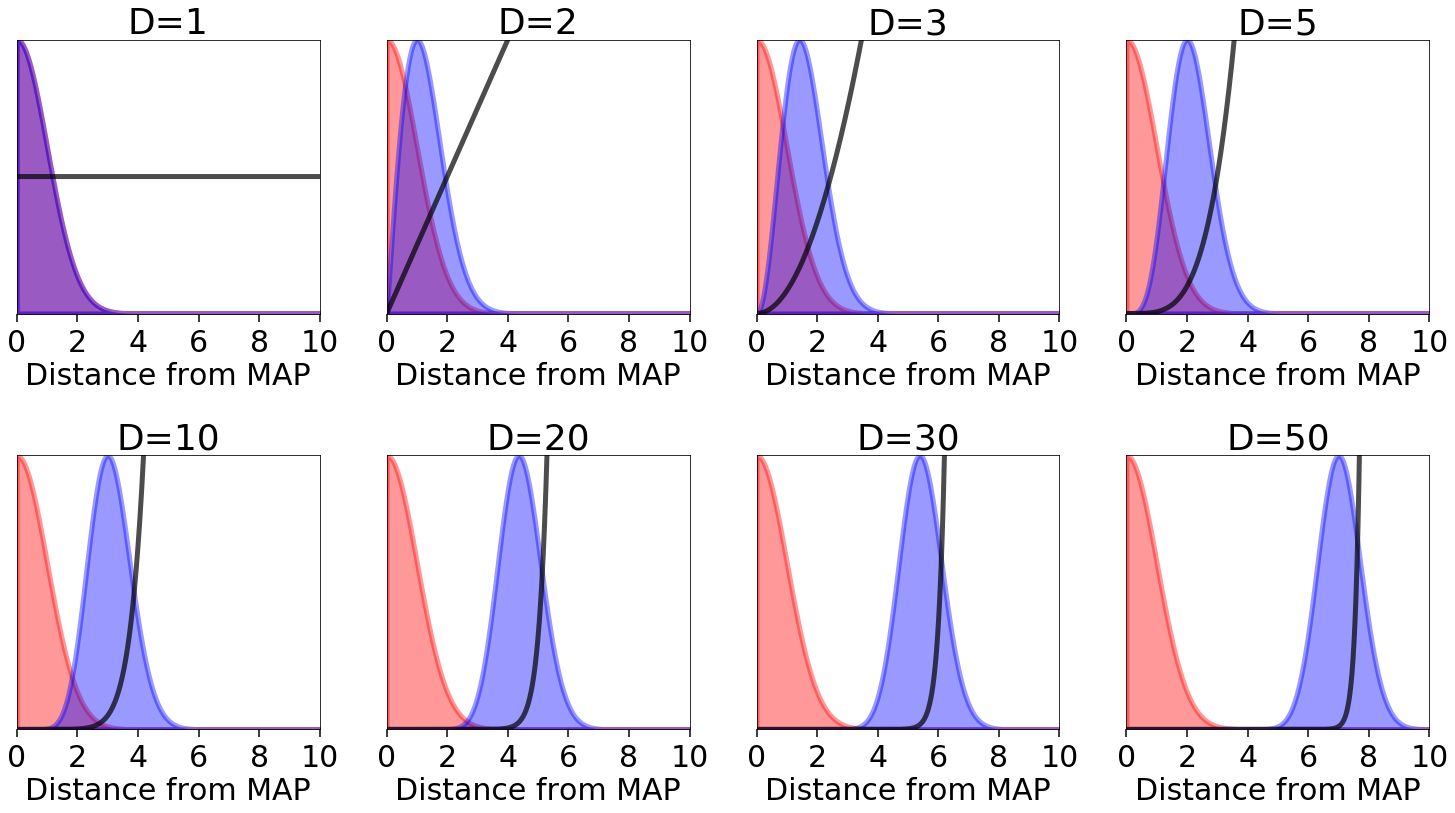

In [3]:
dims = np.array([1, 2, 3, 5, 10, 20, 30, 50])  # dimensions
r = np.linspace(0, 10, 10000)  # radius grid
y = np.exp(-r**2 / 2)  # Gaussian
dv = np.array([r**(d-1) for d in dims])  # differential volume

# plot results
fig, axes = plt.subplots(2, 4, figsize=(21, 12))  # 2x4 plot
for ax, dvol, d in zip(axes.flatten(), dv, dims):
    ax.fill_between(r, y, lw=5, color='red', alpha=0.4)  # posterior
    ts = dvol * y / max(dvol * y)  # typical set
    xmax = ts.argmax()
    ax.fill_between(r, ts, lw=5, color='blue', alpha=0.4)  # plot typical set
    ax.plot(r, dvol / dvol[xmax] / d / 2., lw=5, color='black', alpha=0.7)  # plot dvol
    
    # prettify
    ax.set_xlim([0., 10.])
    ax.set_ylim([0., 1.])
    ax.set_xticks(np.arange(0, 10+1, 2))
    ax.set_xlabel('Distance from MAP')
    ax.set_yticks([])
    ax.set_title('D={0}'.format(d))
fig.tight_layout()

We see that in higher dimensions the typical set can be quite far from the mode. Indeed, it can be $>5\sigma$ away! This does not jive with our basic intuition: a point $5\sigma$ away is *supposed* to be really unlikely. And it is! It just happens that there are many, many more "unlikely" points available (indeed, there are $r^D$ more!) and so they are ultimately more *probable*.

This is the crux of the MCMC problem: a "typical" point actually often occupies a relatively thin shell surrounding the MAP. To draw samples we actually need to sample from this shell. This offers a dramatically different picture compared to how we typically think about sampling from posteriors using MCMC. Rather than spending more time near the MAP, our chains should actually be spending times in this shell surrounding the map.

## Metropolis-Hastings

This tension between the volume of $\boldsymbol{\Theta}$ which scales exponentially with $D-1$ and the posterior $p(\boldsymbol{\Theta}$ over $\boldsymbol{\Theta}$ is a problem that is at the heart of MCMC. Take the **Metropolis update**:

$$ A(\boldsymbol{\Theta}^\prime| \boldsymbol{\Theta}) = \min \left(1, {\frac {p(\boldsymbol{\Theta}^\prime)}{p(\boldsymbol{\Theta})}}{\frac {g(\boldsymbol{\Theta}|\boldsymbol{\Theta}^\prime)}{g(\boldsymbol{\Theta}^\prime|\boldsymbol{\Theta})}}\right) $$

Right there we see the tension: the posterior ratio $p(\boldsymbol{\Theta}^\prime) / p(\boldsymbol{\Theta})$ prefers keeping the chain closer to the MAP while the proposal ratio $g(\boldsymbol{\Theta}|\boldsymbol{\Theta}^\prime)/g(\boldsymbol{\Theta}^\prime|\boldsymbol{\Theta})$ prefers the chain to wander away (since there's many more values of $\boldsymbol{\Theta}$ away from the mode).

Let's simulate this process. First we define a simple a **Metropolis-Hastings (MH) sampler** which proposes new locations in a multivariate Gaussian around our current position. Since MH is a local proposal, it ultimately becomes limited by the local volume of shell in the immediate vicinity of the chains, which often requires reducing the scope of $g(\boldsymbol{\Theta}^\prime|\boldsymbol{\Theta})$ as $D$ increases. To generate independent and identically distributed (i.i.d.) samples within the typical set, however, we need to draw samples randomly around the shell. This means we are forced to wait ever longer for chains to random walk around the shell until they become memoryless. 

In [4]:
# define our MH sampler

def mh_tprob(lnp_prop, lnp_old):
    """MH transition probability."""
    
    return np.exp(lnp_prop - lnp_old)

def mh_update(pos, lnp, prop_cov, lnprobfn):
    """Execute a MH update."""
    
    dpos = np.random.multivariate_normal(np.zeros_like(pos), prop_cov)  # jitter
    pos_new = pos + dpos  # propose new position
    lnp_new = lnprobfn(pos_new)  # new lnP
    tprob = mh_tprob(lnp_new, lnp)  # transition probability 
    
    # accept/reject new position
    if np.random.rand() <= tprob:
        return pos_new, lnp_new
    else:
        return pos, lnp

def mh_sampler(N, pos, lnp, prop_cov, lnprobfn, thin=1, verbose=True):
    """A simple MH sampler."""
    
    pos_chain, lnp_chain = [], []  # intialize chain
    
    count = 0
    n = 0
    while n < N:
        if verbose and n%1000 == 0 and count == 0: 
            sys.stderr.write(str(n)+' ')
        pos, lnp = mh_update(pos, lnp, prop_cov, lnprobfn)  # MH update
        if (count + 1) % thin == 0:
            pos_chain.append(pos.copy())  # add new position
            lnp_chain.append(lnp)  # add new lnprob
            count = 0
            n += 1
        else:
            count += 1
        
    return np.array(pos_chain), np.array(lnp_chain)

Once we define our (log-)posterior, we're then good to go!

In [5]:
# define our log-posterior
def logp(x):
    """Simple Gaussian log-posterior."""
    try:
        return -0.5 * np.sum(x**2, axis=1)
    except:
        return -0.5 * sum(x**2)

In [6]:
Niter = 10000  # number of iterations
pos_mh = []  # list of positions
for d in dims:
    prop_cov = np.identity(d)  # diagonal of our gaussian proposal distribution
    pos_init = np.atleast_1d(np.random.randn(d))  # initial position (already burned in)
    lnp_init = logp(pos_init)  # initial ln(prob)
    
    # sample!
    sys.stderr.write('D={0}: '.format(d))
    pos_chain_mh, lnp_chain_mh = mh_sampler(Niter, pos_init, lnp_init, 
                                            prop_cov, logp, thin=20)
    sys.stderr.write('\n')
    pos_mh.append(pos_chain_mh)

D=1: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 
D=2: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 
D=3: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 
D=5: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 
D=10: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 
D=20: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 
D=30: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 
D=50: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 


Let's see how we did.

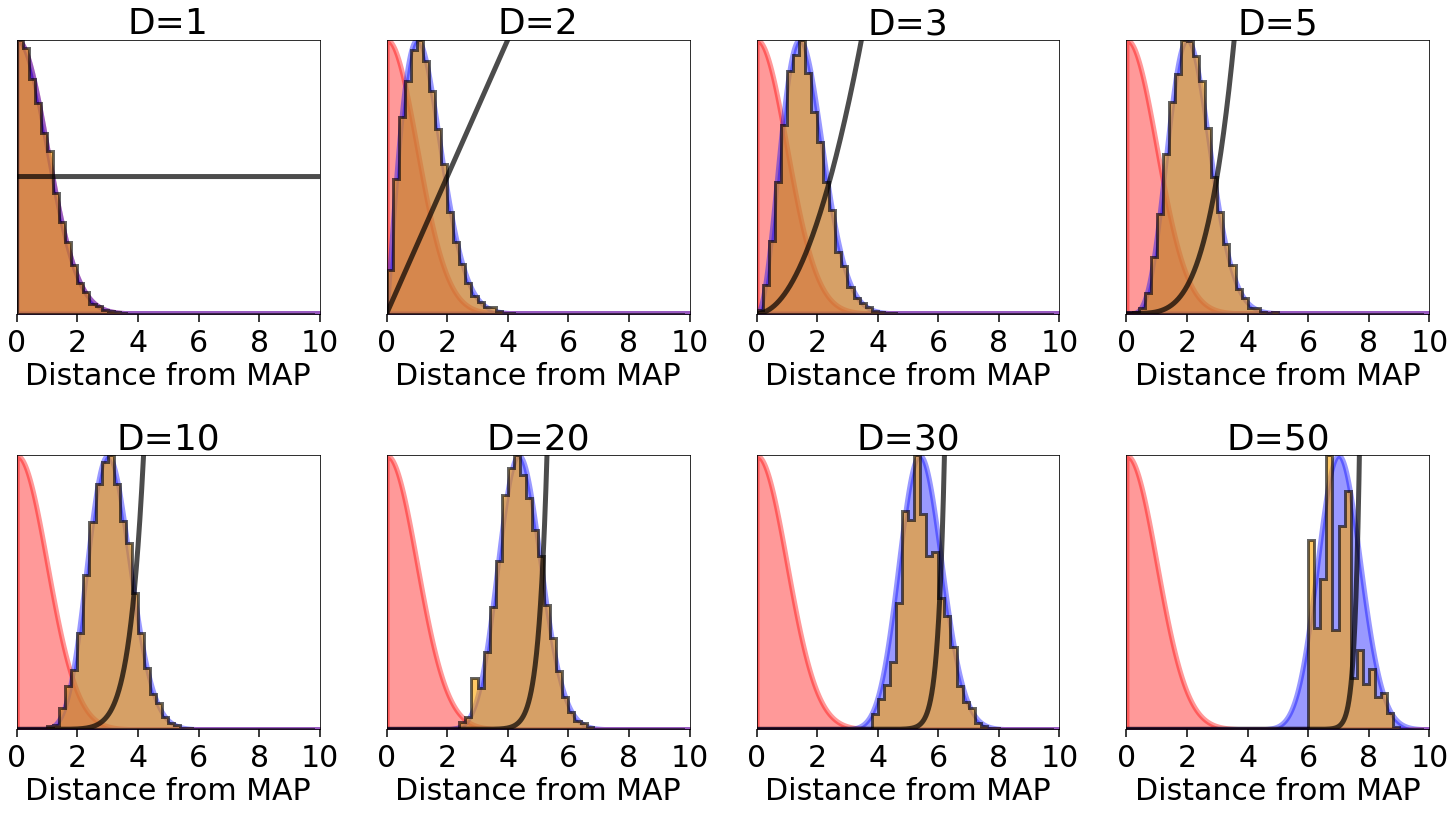

In [7]:
fig, axes = plt.subplots(2, 4, figsize=(21, 12))  # 2x4 plot
for ax, dvol, d, pmh in zip(axes.flatten(), dv, dims, pos_mh):
    ax.fill_between(r, y, lw=5, color='red', alpha=0.4)  # posterior
    ts = dvol * y / max(dvol * y)
    xmax = ts.argmax()
    ax.fill_between(r, ts, lw=5, color='blue', alpha=0.4)  # typical set
    ax.plot(r, dvol / dvol[xmax] / d / 2., lw=5, color='black', alpha=0.7)  # dvol
    
    # add MH samples
    radius = np.sqrt(np.sum(pmh**2, axis=1))
    N, __ = np.histogram(radius, bins=r[::200])
    __ = ax.hist(radius, bins=r[::200], alpha=0.6, lw=3, color='orange',
                 histtype='stepfilled', edgecolor='black',
                 weights=np.ones(len(radius)) * 1. / max(N))
    
    # prettify
    ax.set_xlim([0., 10.])
    ax.set_ylim([0., 1.])
    ax.set_xticks(np.arange(0, 10+1, 2))
    ax.set_xlabel('Distance from MAP')
    ax.set_yticks([])
    ax.set_title('D={0}'.format(d))
fig.tight_layout()

And voila! Our MH sampler is probing the typical set, as expected. Or, at least it's trying to up until $D=50$, where it finally begins to break (where our proposal term just gives too many bad proposals).

## (In)efficient Proposals

Another way to think about what proposals are "good" for MCMC is to ask what "ideal" proposals would look like from $\boldsymbol{\Theta} \rightarrow \boldsymbol{\Theta}^\prime$. We can reduce this to a simpler metric to gain some more intuition: if we just simulated random draws from the posterior, what would be the average distance of our update? If our sampler is functioning perfectly, it should be able to reproduce *both* the typical distance from the MAP *and* the typical separation. Let's first take a look at the ideal case.

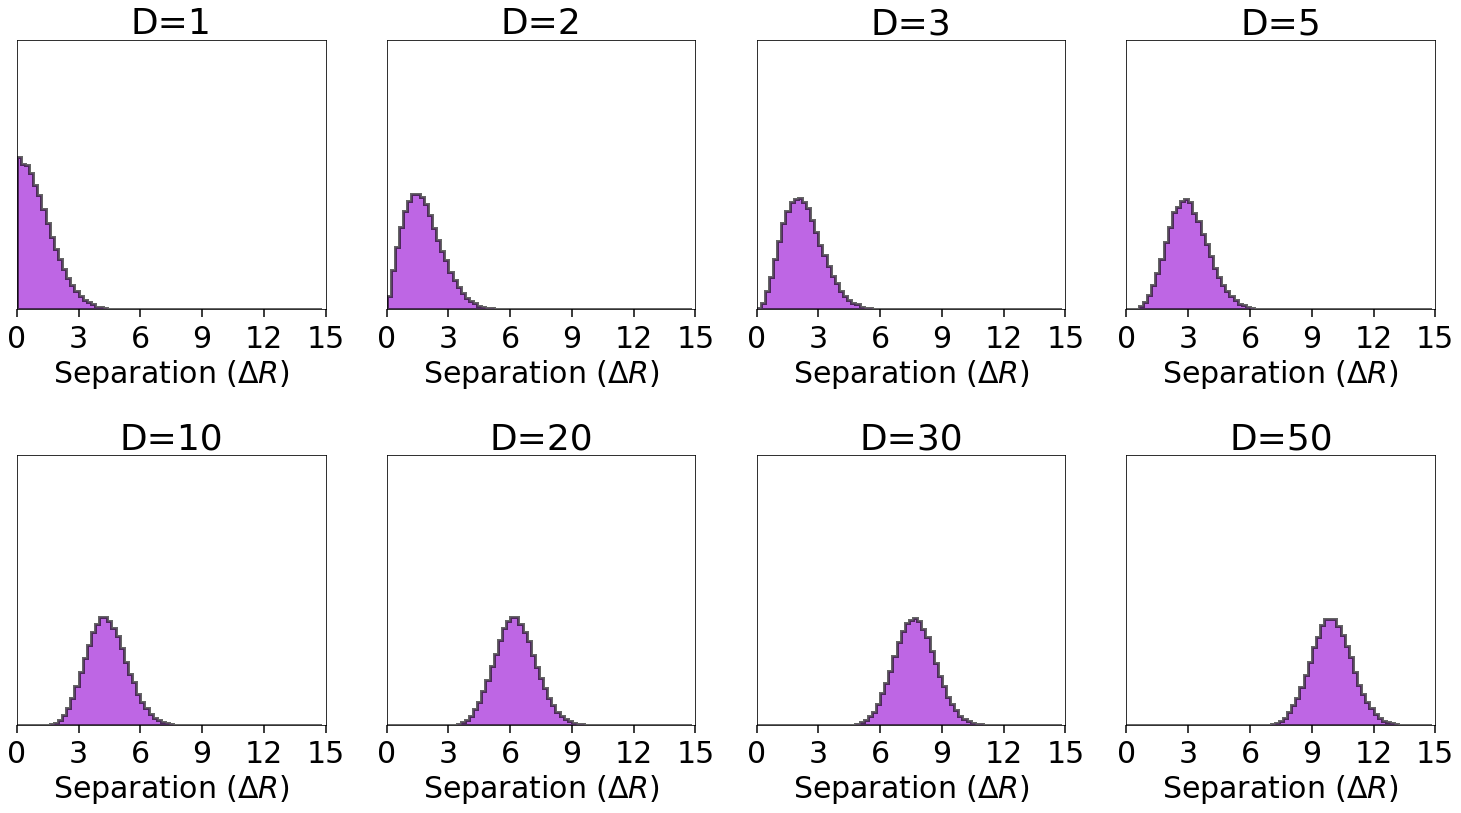

In [8]:
# ideal case
r2 = np.linspace(0, 15, 15000)
Nmc = 100000

fig, axes = plt.subplots(2, 4, figsize=(21, 12))  # 2x4 plot
for ax, d in zip(axes.flatten(), dims):
    x = np.random.randn(Nmc, d)  # samples
    dx = np.sqrt(np.sum((x[1:] - x[:-1])**2, axis=1))  # distances
    __ = ax.hist(dx, bins=r2[::200], alpha=0.6,
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='darkviolet', normed=True)
    
    # prettify
    ax.set_xlim([0., 15.])
    ax.set_xticks(np.arange(0, 15+1, 3))
    ax.set_xlabel(u'Separation ($\Delta R$)')
    ax.set_yticks([])
    ax.set_ylim([0., 1.])
    ax.set_title('D={0}'.format(d))
fig.tight_layout()

How does our MH sampler compare in terms of proposals?

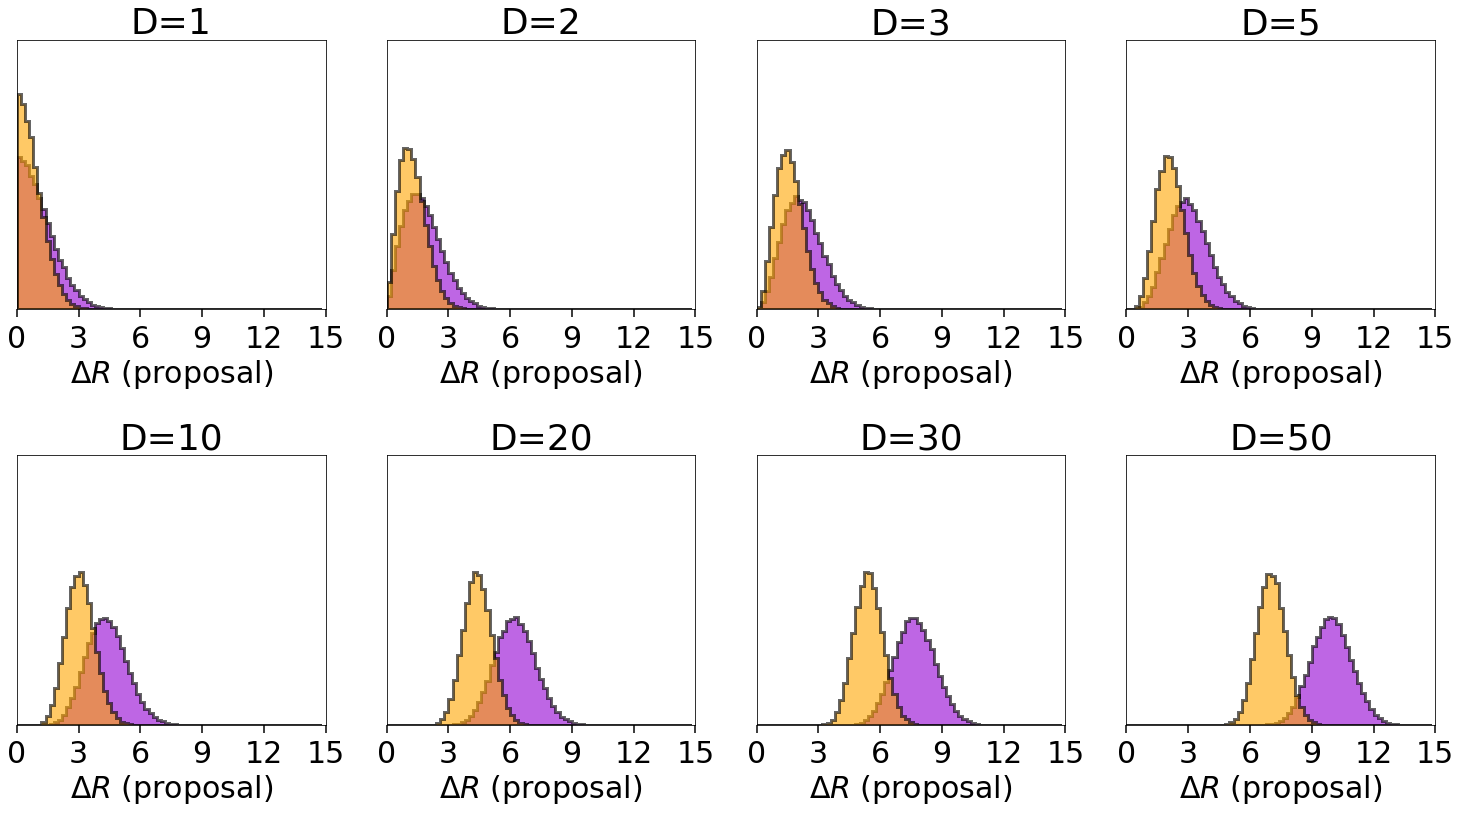

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(21, 12))  # 2x4 plot
for ax, d in zip(axes.flatten(), dims):
    
    # ideal case
    x = np.random.randn(Nmc, d)
    dx = np.sqrt(np.sum((x[1:] - x[:-1])**2, axis=1))
    __ = ax.hist(dx, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='darkviolet', normed=True)
    
    # MH case
    x_mh = np.random.randn(Nmc, d)
    dx_mh = np.sqrt(np.sum(x_mh**2, axis=1))
    __ = ax.hist(dx_mh, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='orange', normed=True)
    
    # prettify
    ax.set_xlim([0., 15.])
    ax.set_xticks(np.arange(0, 15+1, 3))
    ax.set_xlabel(u'$\Delta R$ (proposal)')
    ax.set_yticks([])
    ax.set_ylim([0., 1.])
    ax.set_title('D={0}'.format(d))
fig.tight_layout()

As expected, we propose systematically smaller distances than desired (and this is excluding things like acceptance fractions). Given that we're aiming for the typical set, this behavior also isn't necessarily great: overshooting the typical set is extremely inefficient. That said, how do we do in practice?

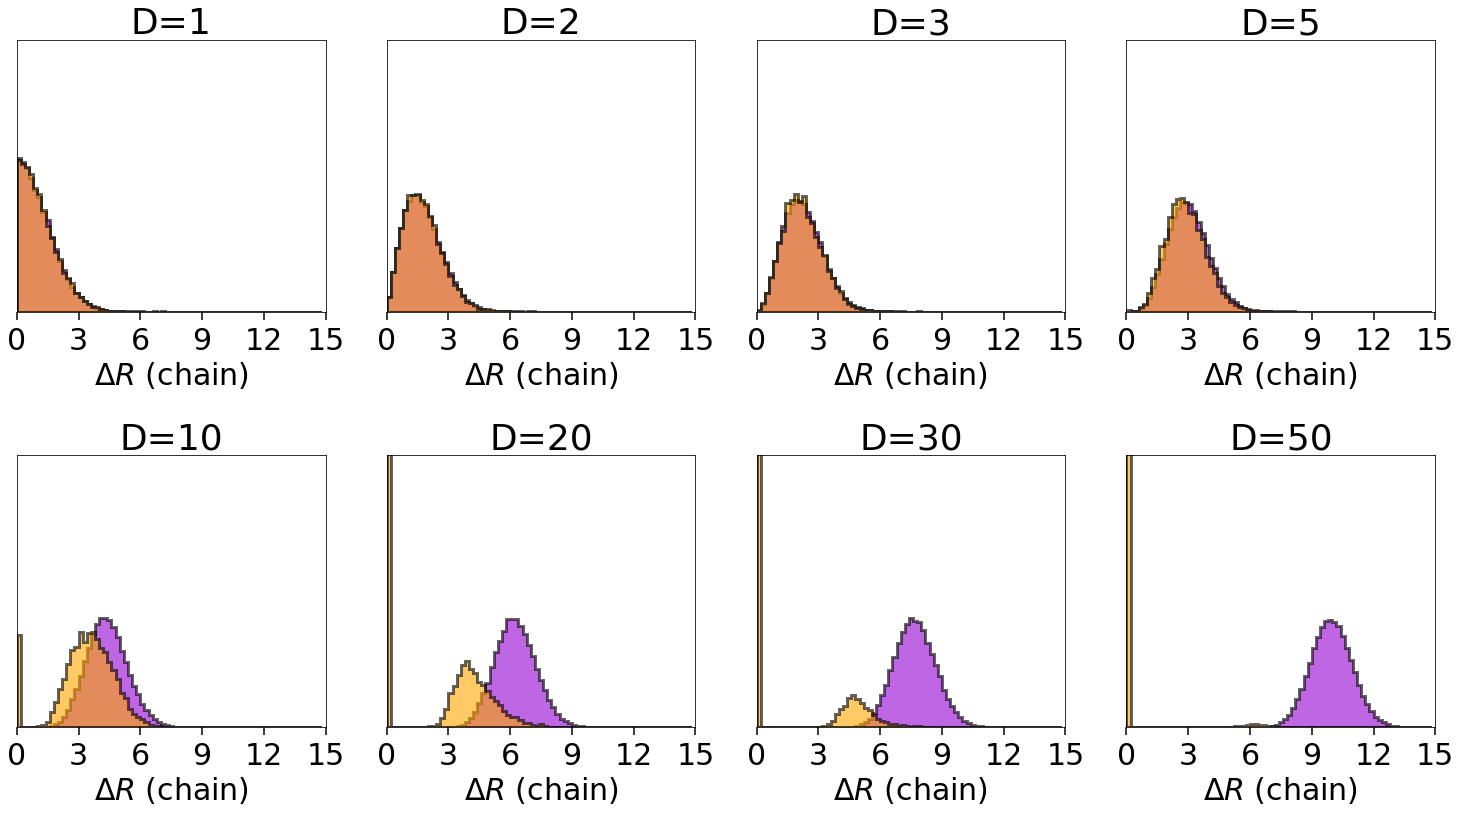

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(21, 12))  # 2x4 plot
for ax, d, pmh in zip(axes.flatten(), dims, pos_mh):
    
    # ideal case
    x = np.random.randn(Nmc, d)
    dx = np.sqrt(np.sum((x[1:] - x[:-1])**2, axis=1))
    __ = ax.hist(dx, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='darkviolet', normed=True)
    
    # MH case
    dx_mh = np.sqrt(np.sum((pmh[1:] - pmh[:-1])**2, axis=1))
    __ = ax.hist(dx_mh, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='orange', normed=True)
    
    # prettify
    ax.set_xlim([0., 15.])
    ax.set_xticks(np.arange(0, 15+1, 3))
    ax.set_xlabel(u'$\Delta R$ (chain)')
    ax.set_yticks([])
    ax.set_ylim([0., 1.])
    ax.set_title('D={0}'.format(d))
fig.tight_layout()

As expected, in higher dimensions we often get "stuck" trying to move to new positions. Ideally, we would try and scale our proposals to target a certain efficiency (often ~15% or so), which would keep the distribution of the MH proposals above centered around smaller radii. Note that, by construction, this will increase the autocorrelation among samples and lead to more extensive thinning of the results, leading to even longer runtimes. Since our typical proposal distance scales as $\sqrt{d}$, we just need to introduce a term to try and compensate for this effect.

In [11]:
Niter = 10000
pos_amh = []
for d in dims:
    prop_cov = np.identity(d) / d  # proposal distribution
    pos_init = np.atleast_1d(np.random.randn(d))  # initial position
    lnp_init = logp(pos_init)  # initial ln(prob)
    
    # sample!
    sys.stderr.write('D={0}: '.format(d))
    pos_chain_amh, lnp_chain_amh = mh_sampler(Niter, pos_init, lnp_init, 
                                            prop_cov, logp, thin=20)
    sys.stderr.write('\n')
    pos_amh.append(pos_chain_amh)

D=1: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 
D=2: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 
D=3: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 
D=5: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 
D=10: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 
D=20: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 
D=30: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 
D=50: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 


How about now?

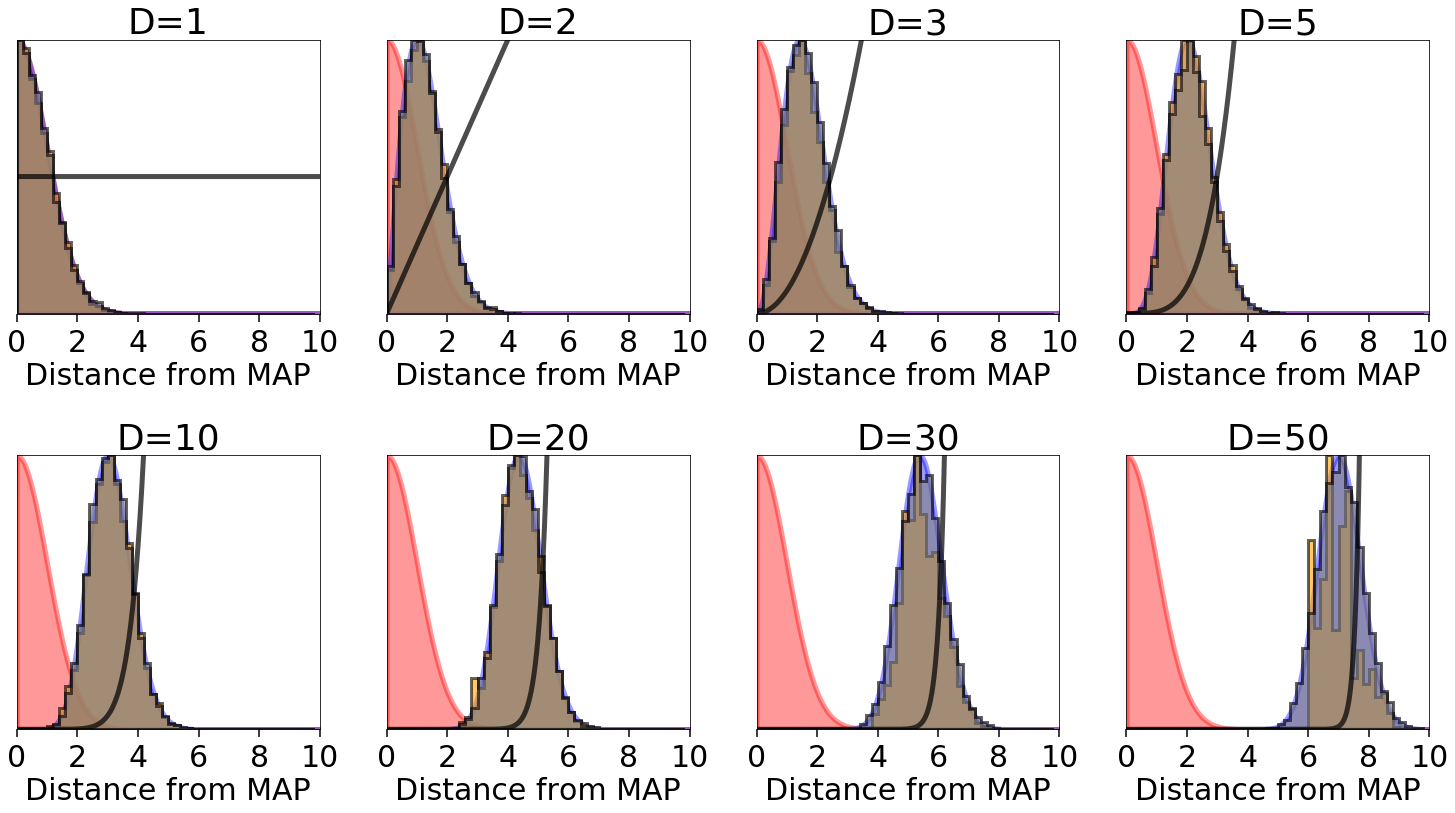

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(21, 12))  # 2x4 plot
for ax, dvol, d, pmh, pamh in zip(axes.flatten(), dv, dims, pos_mh, pos_amh):
    ax.fill_between(r, y, lw=5, color='red', alpha=0.4)  # posterior
    ts = dvol * y / max(dvol * y)
    xmax = ts.argmax()
    ax.fill_between(r, ts, lw=5, color='blue', alpha=0.4)  # typical set
    ax.plot(r, dvol / dvol[xmax] / d / 2., lw=5, color='black', alpha=0.7)  # dvol
    
    # add MH samples
    radius = np.sqrt(np.sum(pmh**2, axis=1))
    N, __ = np.histogram(radius, bins=r[::200])
    __ = ax.hist(radius, bins=r[::200], alpha=0.6, lw=3, color='orange', 
                 histtype='stepfilled', edgecolor='black',
                 weights=np.ones(len(radius)) * 1. / max(N))

    # add AMH samples
    radius = np.sqrt(np.sum(pamh**2, axis=1))
    N, __ = np.histogram(radius, bins=r[::200])
    __ = ax.hist(radius, bins=r[::200], alpha=0.6, lw=3, color='gray', 
                 histtype='stepfilled', edgecolor='black',
                 weights=np.ones(len(radius)) * 1. / max(N))
    
    # prettify
    ax.set_xlim([0., 10.])
    ax.set_ylim([0., 1.])
    ax.set_xticks(np.arange(0, 10+1, 2))
    ax.set_xlabel('Distance from MAP')
    ax.set_yticks([])
    ax.set_title('D={0}'.format(d))
fig.tight_layout()

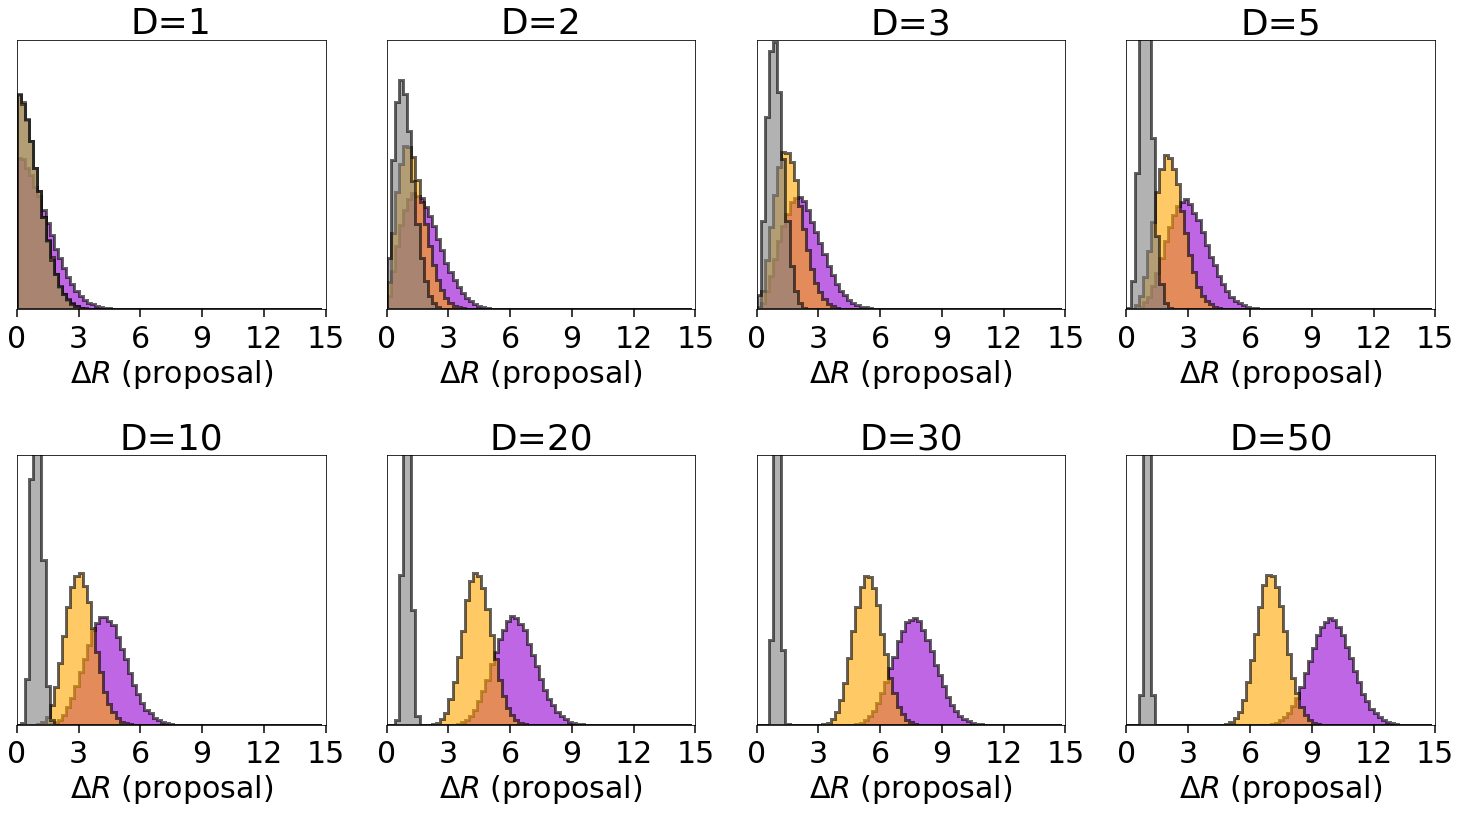

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(21, 12))  # 2x4 plot
for ax, d in zip(axes.flatten(), dims):
    
    # ideal case
    x = np.random.randn(Nmc, d)
    dx = np.sqrt(np.sum((x[1:] - x[:-1])**2, axis=1))
    __ = ax.hist(dx, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='darkviolet', normed=True)
    
    # MH case
    x_mh = np.random.randn(Nmc, d)
    dx_mh = np.sqrt(np.sum(x_mh**2, axis=1))
    __ = ax.hist(dx_mh, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='orange', normed=True)
    
    # AMH case
    x_amh = np.random.randn(Nmc, d) / np.sqrt(d)
    dx_amh = np.sqrt(np.sum(x_amh**2, axis=1))
    __ = ax.hist(dx_amh, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='gray', normed=True)
    
    # prettify
    ax.set_xlim([0., 15.])
    ax.set_xticks(np.arange(0, 15+1, 3))
    ax.set_xlabel(u'$\Delta R$ (proposal)')
    ax.set_yticks([])
    ax.set_ylim([0., 1.])
    ax.set_title('D={0}'.format(d))
fig.tight_layout()

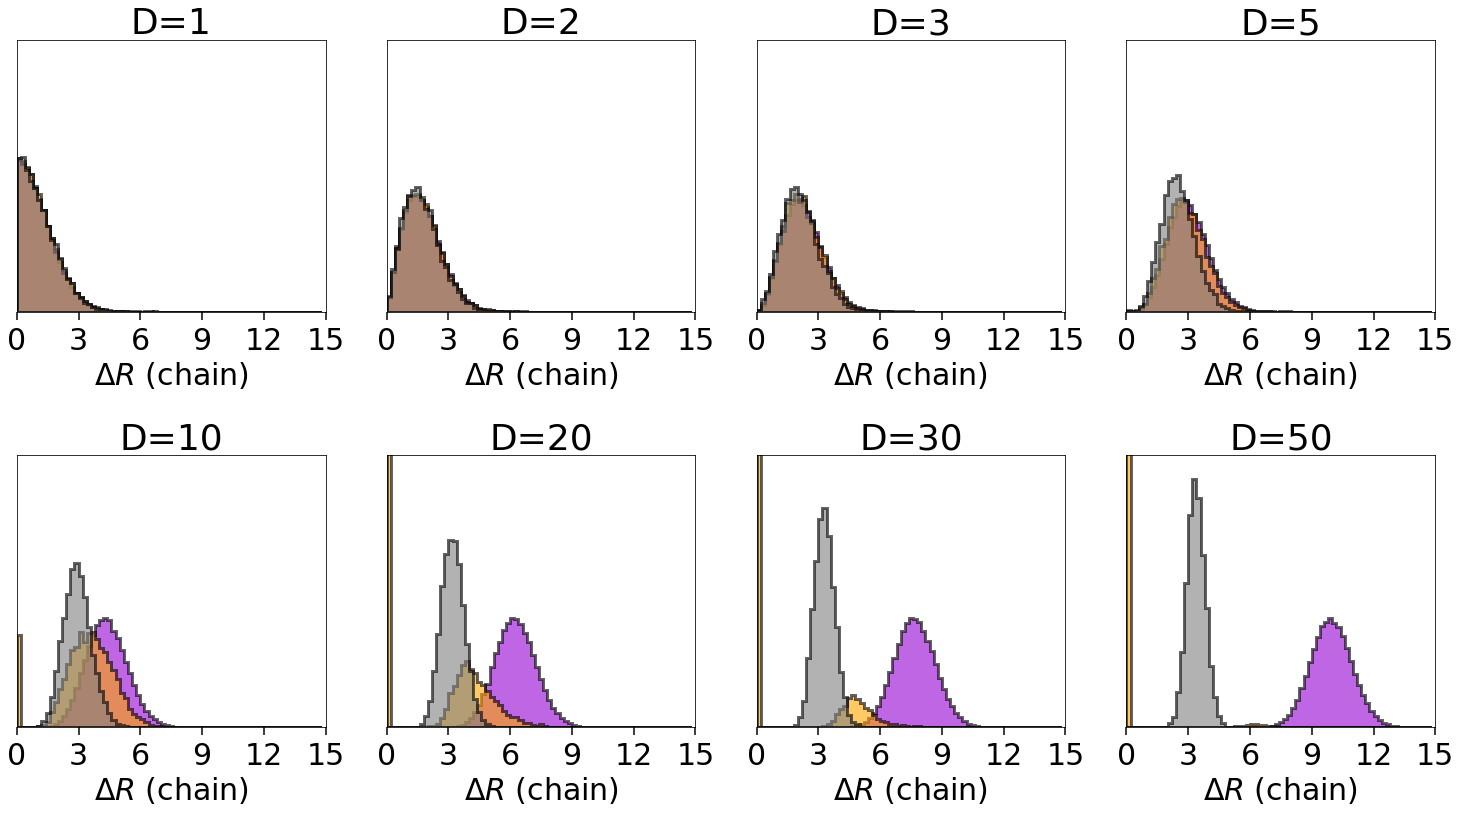

In [14]:
fig, axes = plt.subplots(2, 4, figsize=(21, 12))  # 2x4 plot
for ax, d, pmh, pamh in zip(axes.flatten(), dims, pos_mh, pos_amh):
    
    # ideal case
    x = np.random.randn(Nmc, d)
    dx = np.sqrt(np.sum((x[1:] - x[:-1])**2, axis=1))
    __ = ax.hist(dx, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='darkviolet', normed=True)
    
    # MH case
    dx_mh = np.sqrt(np.sum((pmh[1:] - pmh[:-1])**2, axis=1))
    __ = ax.hist(dx_mh, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='orange', normed=True)
    
    # AMH case
    dx_amh = np.sqrt(np.sum((pamh[1:] - pamh[:-1])**2, axis=1))
    __ = ax.hist(dx_amh, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='gray', normed=True)
    
    # prettify
    ax.set_xlim([0., 15.])
    ax.set_xticks(np.arange(0, 15+1, 3))
    ax.set_xlabel(u'$\Delta R$ (chain)')
    ax.set_yticks([])
    ax.set_ylim([0., 1.])
    ax.set_title('D={0}'.format(d))
fig.tight_layout()

We're clearly not thinning enough, especially in higher dimensions, but our proposals are now much more stable and their (radial) distribution matches what we'd expect from our idealized samples, so at the overall behavior is roughly consistent. We can get a sense for how this looks like in practice by plotting 1-D traces of our samples, shown below.

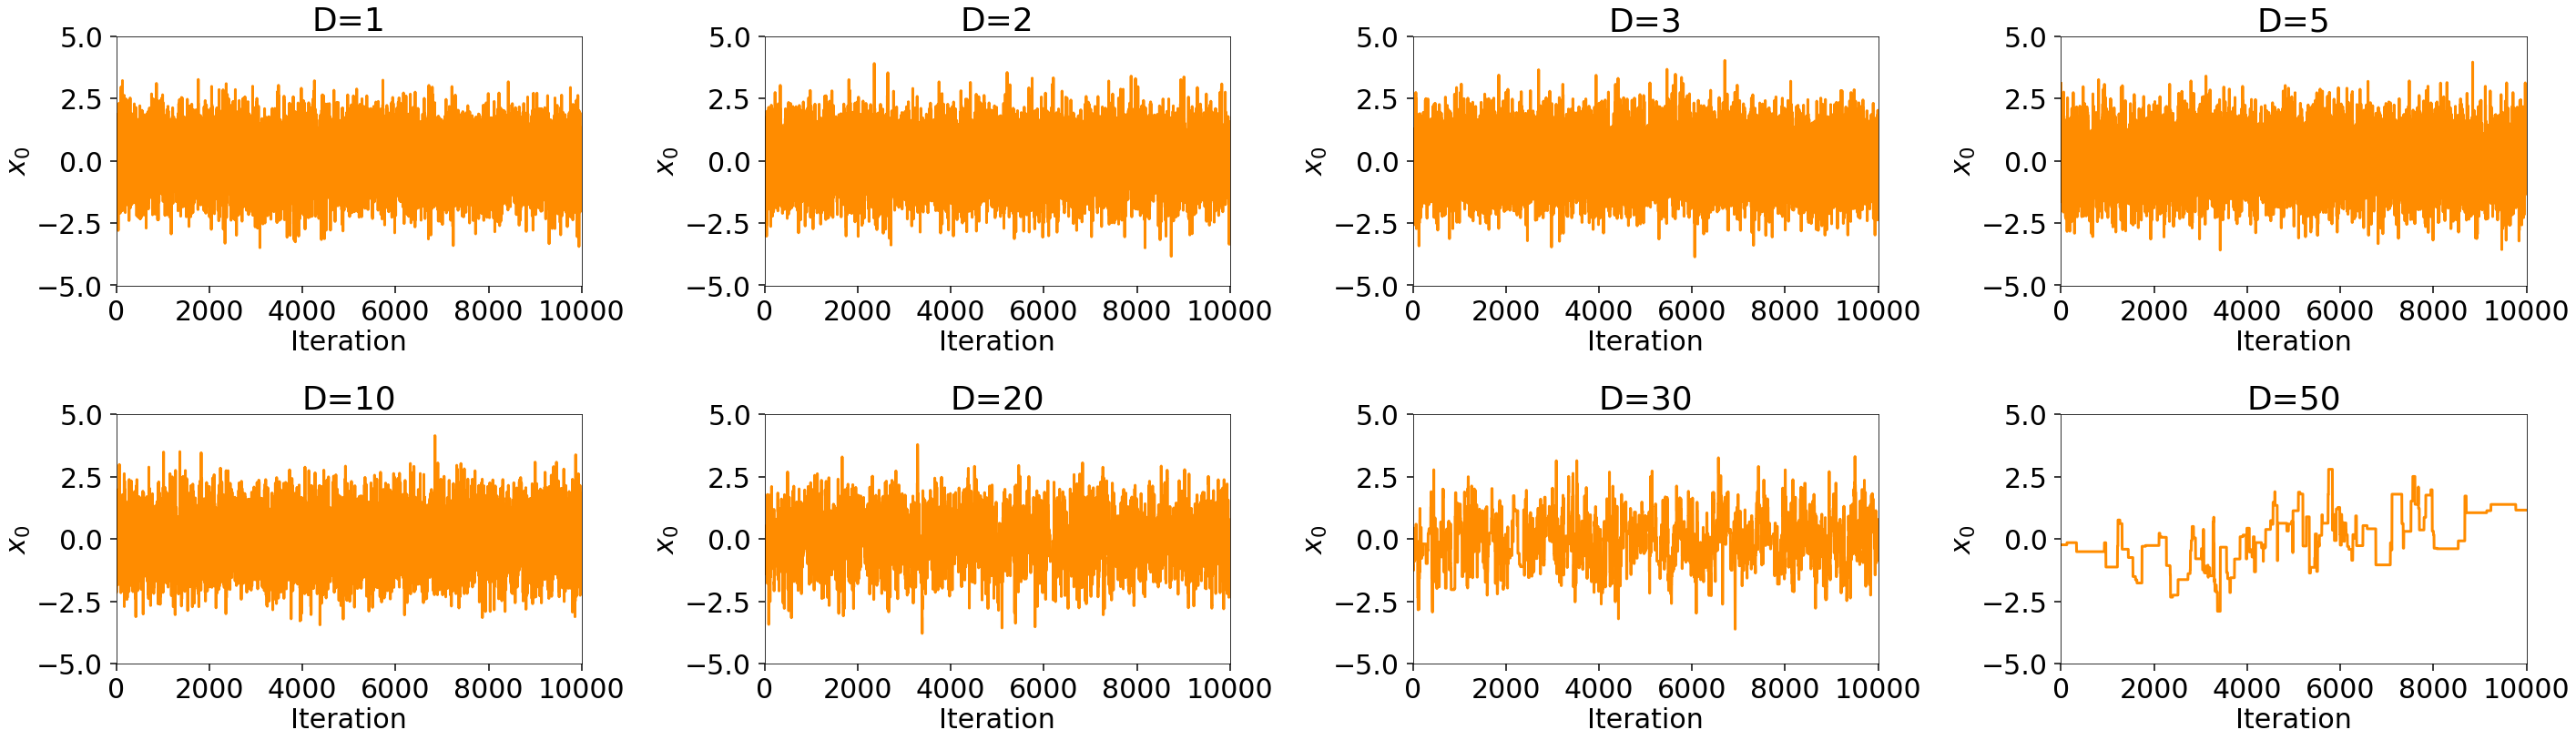

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(40, 12))  # 2x4 plot
for ax, d, x in zip(axes.flatten(), dims, pos_mh):
    
    ax.plot(x[:,0], color='darkorange', lw=3)

    # prettify
    ax.set_xlim([0., Niter])
    ax.set_xlabel('Iteration')
    ax.set_ylim([-5., 5.])
    ax.set_ylabel(u"$x_0$")
    ax.set_title('D={0}'.format(d))
fig.tight_layout()

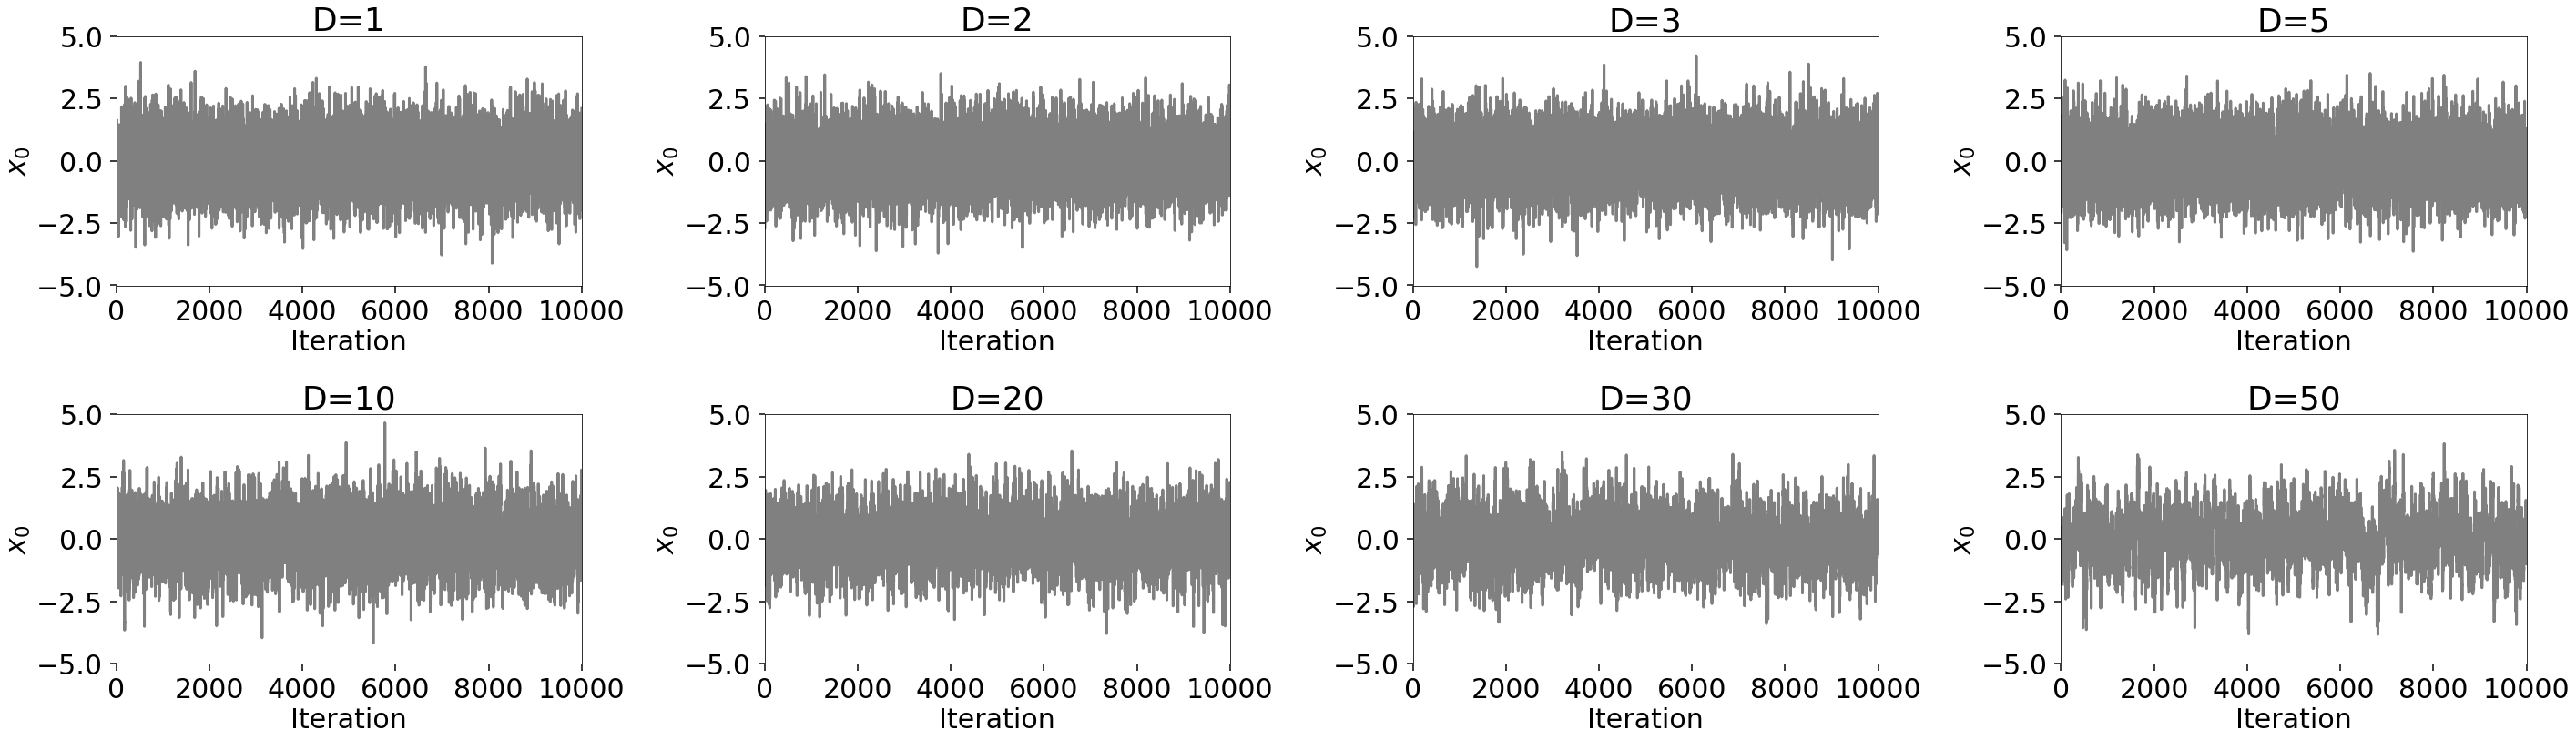

In [16]:
fig, axes = plt.subplots(2, 4, figsize=(40, 12))  # 2x4 plot
for ax, d, x in zip(axes.flatten(), dims, pos_amh):
    
    ax.plot(x[:,0], color='gray', lw=3)
    
    # prettify
    ax.set_xlim([0., Niter])
    ax.set_xlabel('Iteration')
    ax.set_ylim([-5., 5.])
    ax.set_ylabel(u"$x_0$")
    ax.set_title('D={0}'.format(d))
fig.tight_layout()

## Ensemble Sampling

Based on what we've seen above, we can now examine basic idea of ensemble sampling with a new, critical eye. The idea in ensemble sampling is to use a (large) collection of particles to determine the proposals rather than proposing new moves locally. The basic idea is that the particles will adapt to the shape of the posterior, leading to more efficient proposals over time. 

This makes a lot of intuitive sense: particles can align along particular axes, stretch/squish to fill/compress space, and otherwise move around with the posterior. 

It also makes basic statistical sense: if we're sampling a Gaussian with covariance $\boldsymbol{\Sigma}$, then our collection of $K$ particles at positions $\lbrace \boldsymbol{\Theta}_1, \dots,  \boldsymbol{\Theta}_K \rbrace$ will also have covariance $\boldsymbol{\hat{\Sigma}} \approx \boldsymbol{\Sigma}$ and so proposals will naturally align along the principle covariant axes, no "tuning" of any proposals needed! This also extends to more complex distributions, which can be seen (roughly) as arbitrary mixtures of Gaussians.

However, our recent results should give us pause: while these findings do indeed seem intuitive, ensemble methods might not actually behave as we expect. For instance, take the affine-invariant sampler from Goodman & Weare (2010), which is utilized in the popular package `emcee`. It has an MH transition (acceptance) probability expression of

$$ A(\boldsymbol{\Theta}^\prime| \boldsymbol{\Theta}) = \min \left(1, {\frac {p(\boldsymbol{\Theta}^\prime)}{p(\boldsymbol{\Theta})}} Z^{D-1}\right) $$

where 

$$ \boldsymbol{\Theta}^\prime = \boldsymbol{\Theta}_j + Z \times \left[\boldsymbol{\Theta} - \boldsymbol{\Theta}_j\right] $$

given the position of another particle $\boldsymbol{\Theta}_j$ and

$$ Z \sim g(z) = \frac{1}{\sqrt{z}} ~\textrm{from}~\left[\frac{1}{a}, a\right] ~\textrm{and}~ 0 ~\textrm{otherwise} $$

is the "stretch factor", where $a$ is often set to 2.

The $Z^{D-1}$ term is the volume-related term here, and is related to the fact that the stretch move is a linear transformation of the space, changing the determinant by $Z^{D}$. The $Z^{-1}$ factor comes from the particular proposal distribution. 

Already, we might be suspicious this term will exhibit extreme behavior as $D$ becomes large. But before that, let's examine how our proposals match up with our previous results.

In [17]:
# initialize our stretch move

a = 2  # default value
z = np.linspace(1. / a, a, 1000)  # z grid

# define PDF
gz_pdf = 1. / np.sqrt(z) 
gz_pdf /= np.trapz(gz_pdf)

# define CDF
gz_cdf = gz_pdf.cumsum() 
gz_cdf -= gz_cdf[0]
gz_cdf /= gz_cdf[-1]

# stretch move
def stretch():
    """Stretch factor for affine-invariant sampler."""
    
    return np.interp(np.random.rand(), gz_cdf, z)

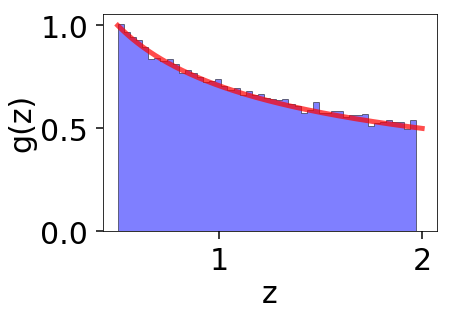

In [18]:
# plot the stretch factor distribution
__ = plt.hist([stretch() for i in range(Nmc)], z[::20], normed=True,
              color='blue', alpha=0.5, histtype='stepfilled', edgecolor='black')
plt.plot(z, gz_pdf/ np.trapz(gz_pdf, z), lw=5, color='red', alpha=0.7)
plt.xlabel('z')
plt.ylabel('g(z)');

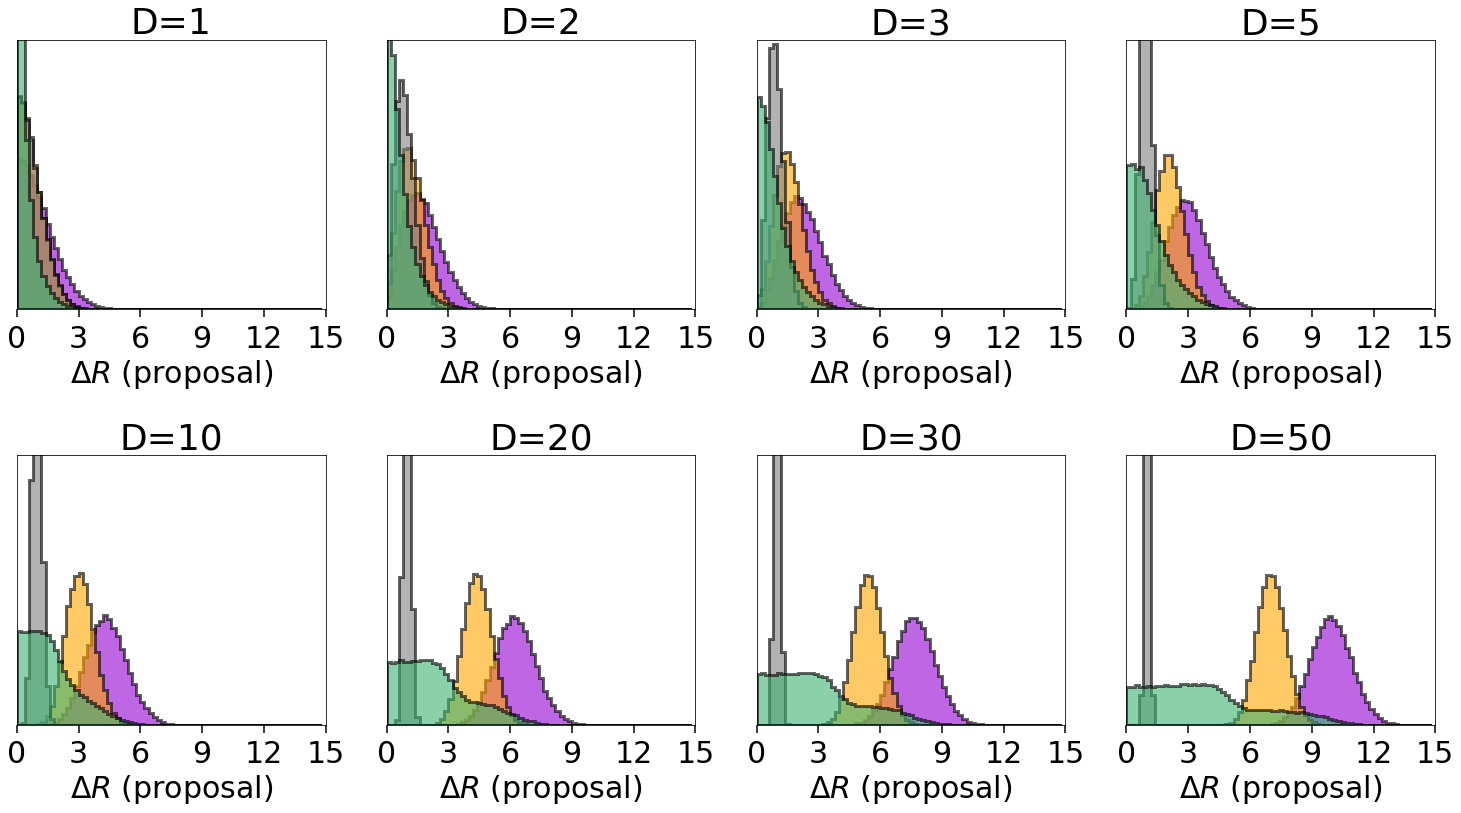

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(21, 12))  # 2x4 plot
for ax, d in zip(axes.flatten(), dims):
    
    # ideal case
    x = np.random.randn(Nmc, d)
    dx = np.sqrt(np.sum((x[1:] - x[:-1])**2, axis=1))
    __ = ax.hist(dx, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='darkviolet', normed=True)
    
    # MH case
    x_mh = np.random.randn(Nmc, d)
    dx_mh = np.sqrt(np.sum(x_mh**2, axis=1))
    __ = ax.hist(dx_mh, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='orange', normed=True)
    
    # AMH case
    x_amh = np.random.randn(Nmc, d) / np.sqrt(d)
    dx_amh = np.sqrt(np.sum(x_amh**2, axis=1))
    __ = ax.hist(dx_amh, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='gray', normed=True)
    
    # emcee case
    x_emcee = np.random.randn(Nmc, d)  # starting position
    xj_emcee = np.random.randn(Nmc, d)  # target particle position
    z_emcee = np.array([stretch() for i in range(Nmc)])  # stretch
    xn_emcee = np.array([xj_emcee[i] + z_emcee[i] * (x_emcee[i] - xj_emcee[i]) 
                         for i in range(Nmc)])  # new position
    dx_emcee = np.sqrt(np.sum((xn_emcee - x_emcee)**2, axis=1))
    __ = ax.hist(dx_emcee, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='mediumseagreen', normed=True)
    
    # prettify
    ax.set_xlim([0., 15.])
    ax.set_xticks(np.arange(0, 15+1, 3))
    ax.set_xlabel(u'$\Delta R$ (proposal)')
    ax.set_yticks([])
    ax.set_ylim([0., 1.])
    ax.set_title('D={0}'.format(d))
fig.tight_layout()

That already looks really weird. We see that our proposals are too centrally concentrated in lower dimensions, even with respect to our adaptive MH proposals (which shrink as $D$ increases), and in high dimensions is extremely diffuse. Given that we nominally want to hit the typical set, the fact that our behavior looks nothing like any of the previous cases is concerning. The "kink" visible in higher dimensions (which tracks the typical separation of particles in the typical set) is a direct consequence of our stretch move scaling distances as $Z^{D}$, which gives divergent behavior as $Z$ departs from 1.

Still, there might be something positive in all this. We haven't yet looked at the effective behavior of our samplers in practice. If we weight our results the probability of acceptance, maybe the actual movement of our sampler to our proposed positions will look more similar to our previous cases.

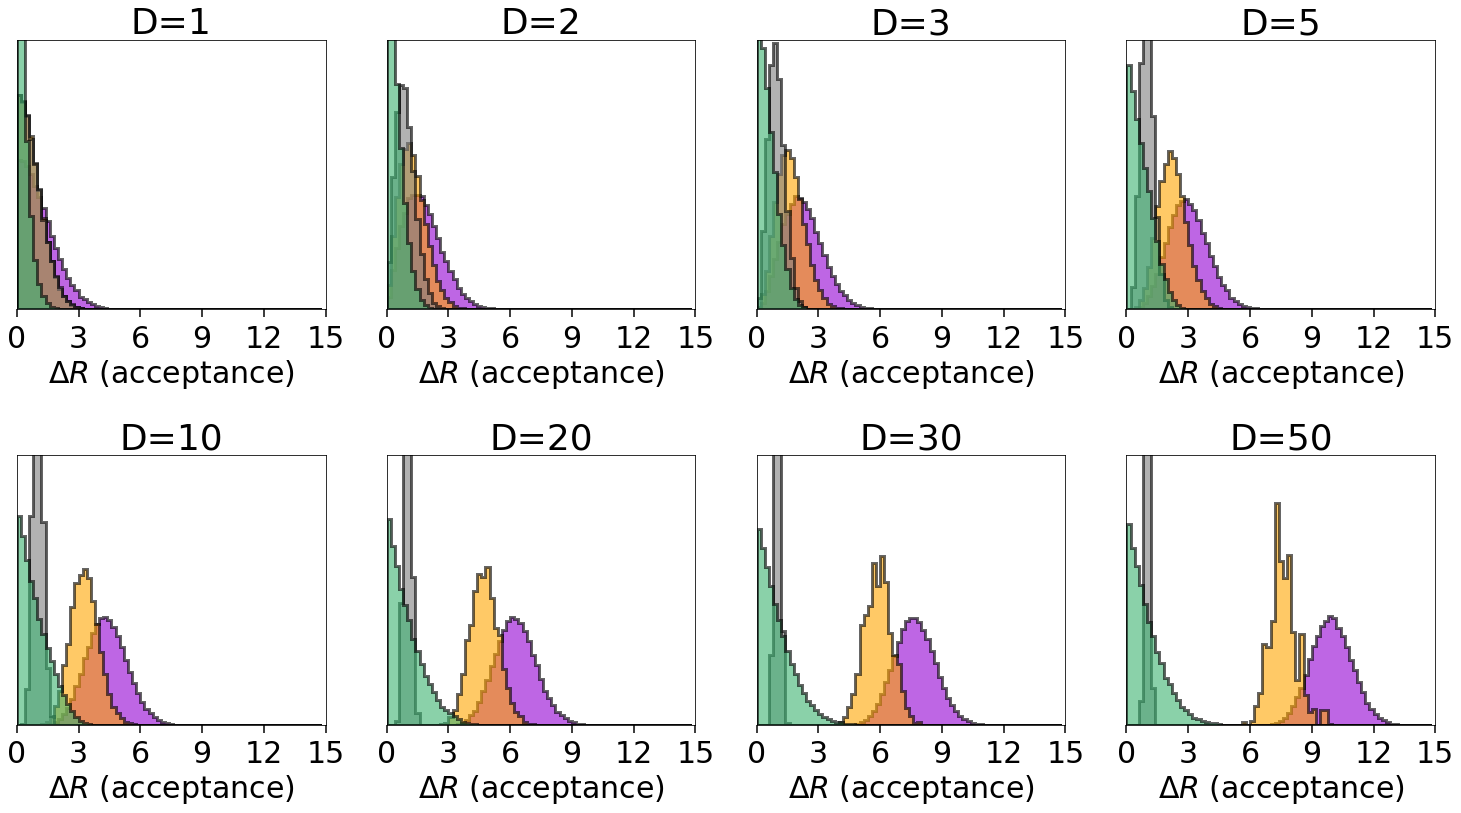

In [20]:
fig, axes = plt.subplots(2, 4, figsize=(21, 12))  # 2x4 plot
for ax, d in zip(axes.flatten(), dims):
    
    # ideal case
    x = np.random.randn(Nmc, d)
    dx = np.sqrt(np.sum((x[1:] - x[:-1])**2, axis=1))
    __ = ax.hist(dx, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='darkviolet', normed=True)
    
    # MH case
    x_mh = np.random.randn(Nmc, d)
    dx_mh = np.sqrt(np.sum(x_mh**2, axis=1))
    p_mh = np.exp(logp(x_mh + np.random.randn(Nmc, d)) - logp(x_mh))
    p_mh[p_mh > 1.] = 1.
    __ = ax.hist(dx_mh, bins=r2[::200], alpha=0.6, 
                 weights=p_mh, histtype='stepfilled', edgecolor='black',
                 lw=3, color='orange', normed=True)
    
    # AMH case
    x_amh = np.random.randn(Nmc, d) / np.sqrt(d)
    dx_amh = np.sqrt(np.sum(x_amh**2, axis=1))
    p_amh = np.exp(logp(x_amh + np.random.randn(Nmc, d)) / np.sqrt(d) - logp(x_amh))
    p_amh[p_amh > 1.] = 1.
    __ = ax.hist(dx_amh, bins=r2[::200], alpha=0.6, 
                 weights=p_amh, histtype='stepfilled', edgecolor='black',
                 lw=3, color='gray', normed=True)
    
    # emcee case
    x_emcee = np.random.randn(Nmc, d)
    xj_emcee = np.random.randn(Nmc, d)
    z_emcee = np.array([stretch() for i in range(Nmc)])
    xn_emcee = np.array([xj_emcee[i] + z_emcee[i] * (x_emcee[i] - xj_emcee[i]) 
                         for i in range(Nmc)])
    dx_emcee = np.sqrt(np.sum((xn_emcee - x_emcee)**2, axis=1))
    p_emcee = np.exp(logp(xn_emcee) - logp(x_emcee)) * z_emcee**(d-1)
    p_emcee[p_emcee > 1.] = 1.
    __ = ax.hist(dx_emcee, bins=r2[::200], alpha=0.6, 
                 weights=p_emcee, histtype='stepfilled', edgecolor='black',
                 lw=3, color='mediumseagreen', normed=True)
    
    # prettify
    ax.set_xlim([0., 15.])
    ax.set_xticks(np.arange(0, 15+1, 3))
    ax.set_xlabel(u'$\Delta R$ (acceptance)')
    ax.set_yticks([])
    ax.set_ylim([0., 1.])
    ax.set_title('D={0}'.format(d))
fig.tight_layout()

We notice that almost all points that are accepted by the affine-invariant stretch moves are systematically skewed towards extremely small radii. This seems counter to our intuition: doesn't the ensemble of particles favor larger positions? And doesn't the stretch move also favor larger moves?

However, if we look back and consider sampling relative to the typical set, we can find explanations for both behaviors. Since our particles are (ideally) distributed within the shell, our stretch moves actually are *incredibly* inefficient proposals: since we're most likely to pick a particle far away from us, our stretch move will take us outside of the shell and be disfavored. **The best proposals are those where we choose particles as close as possible to the local tangent surface of the shell**. While these are the proposals that are precisely disfavored by our stretch move (which prefers larger values), the posterior ratio often more than makes up the difference.

Let's now check how this behavior compares directly using an emcee-like sampler.

In [21]:
# define our emcee-like (affine-invariant ensemble) sampler

def pick_walker(idx, Nwalkers):
    """Select a walker (particle) to use for our proposal."""
    
    return (idx + np.random.randint(1, Nwalkers)) % Nwalkers  # permute index by N-1

def emcee_tprob(lnp_prop, lnp_old, Z, Ndim):
    """Compute emcee transition probability."""
    
    return np.exp(lnp_prop - lnp_old) * Z**(Ndim - 1)

def emcee_walker_update(idx, pos, lnp, lnprobfn, Ndim, Nwalkers, T=1.):
    """Update a walker (particle)."""
    
    idx_new = pick_walker(idx, Nwalkers)  # pick a random walker
    pos_new, pos_old = pos[idx_new], pos[idx]  # grab positions
    Z = stretch()  # sample stretch factor
    pos_prop = pos_new + Z * (pos_old - pos_new)  # propose a new position
    lnp_prop, lnp_old = lnprobfn(pos_prop), lnp[idx]  # compute/grab posteriors
    tprob = emcee_tprob(lnp_prop, lnp_old, Z, Ndim)  # compute transition probability

    # accept/reject
    if np.random.rand() <= tprob:
        return pos_prop, lnp_prop
    else:
        return pos_old, lnp_old

def emcee_sampler(Niter, pos_init, lnp_init, lnprobfn, verbose=True, thin=1):
    """Our emcee-style sampler."""
    
    Nwalkers, Ndim = pos_init.shape  # initialize dimensions
    pos_chain = np.empty((Niter, Nwalkers, Ndim), dtype='float32')  # positions
    lnp_chain = np.empty((Niter, Nwalkers), dtype='float32')  # lnP
    for j in xrange(Nwalkers):
        pos_chain[0, j], lnp_chain[0, j] = emcee_walker_update(j, pos_init, lnp_init, 
                                                               lnprobfn, Ndim, Nwalkers)
    
    # sampling phase
    count = 0
    i = 1
    pos, lnp = pos_init, lnp_init
    while i < Niter:
        if verbose and count == 0: 
            sys.stderr.write(str(i)+' ')
        for j in xrange(Nwalkers):
            pos[j], lnp[j] = emcee_walker_update(j, pos, lnp, lnprobfn, Ndim, Nwalkers)
        if (count + 1) % thin == 0:
            pos_chain[i], lnp_chain[i] = pos, lnp
            count = 0
            i += 1
        else:
            count += 1
    
    return pos_chain, lnp_chain

In [22]:
Niter = 10000
Nwalkers = 250
Nrun = int(Niter / Nwalkers)
pos_emcee = []
for d in dims:
    pos_init = np.atleast_2d(np.random.randn(Nwalkers, d))  # initial position
    lnp_init = logp(pos_init)  # initial ln(prob)
    
    # sample!
    sys.stderr.write('D={0}: '.format(d))
    pos_chain_emcee, lnp_chain_emcee = emcee_sampler(Nrun, pos_init, lnp_init, 
                                                     logp, thin=20)
    sys.stderr.write('\n')
    pos_emcee.append(pos_chain_emcee)

D=1: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 
D=2: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 
D=3: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 
D=5: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 
D=10: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 
D=20: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 
D=30: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 
D=50: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 


We now want to see what the overall behavior looks like, **taking care to keep track of the movement of individual particles when computing our results**. This is critical to examining the behavior of ensemble (particle) samplers, since the behavior of the ensemble can easily mask the behavior of individual particles (and thus our general sampling performance).

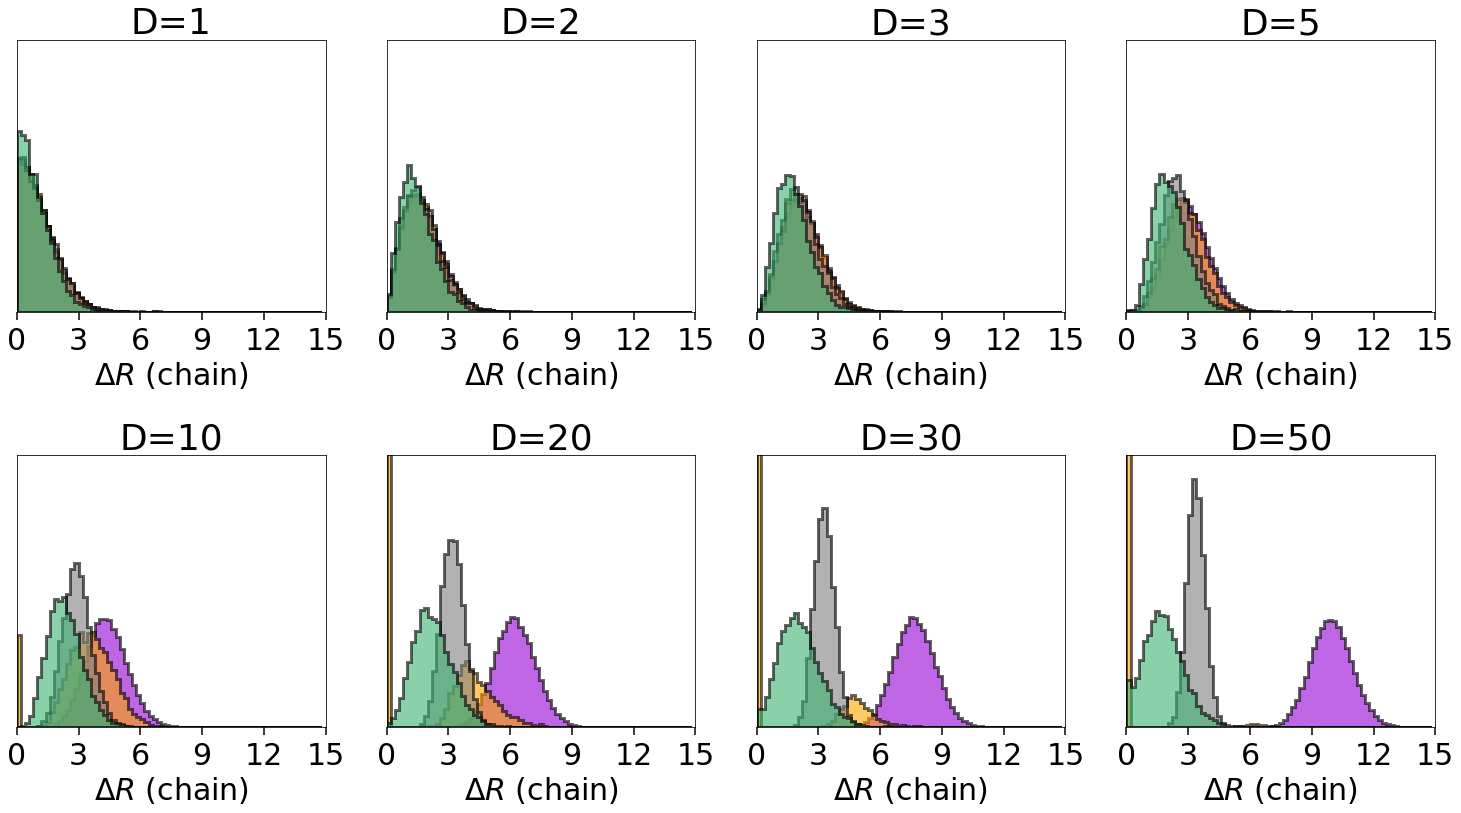

In [23]:
fig, axes = plt.subplots(2, 4, figsize=(21, 12))  # 2x4 plot
for ax, d, pmh, pamh, pemcee in zip(axes.flatten(), dims, pos_mh, 
                                    pos_amh, pos_emcee):
    
    # ideal case
    x = np.random.randn(Nmc, d)
    dx = np.sqrt(np.sum((x[1:] - x[:-1])**2, axis=1))
    __ = ax.hist(dx, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='darkviolet', normed=True)
    
    # MH case
    dx_mh = np.sqrt(np.sum((pmh[1:] - pmh[:-1])**2, axis=1))
    __ = ax.hist(dx_mh, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='orange', normed=True)
    
    # AMH case
    dx_amh = np.sqrt(np.sum((pamh[1:] - pamh[:-1])**2, axis=1))
    __ = ax.hist(dx_amh, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='gray', normed=True)
    
    # emcee case
    dx_emcee = np.sqrt(np.sum((pemcee[1:] - pemcee[:-1])**2, axis=2)).flatten()
    __ = ax.hist(dx_emcee, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='mediumseagreen', normed=True)
    
    # prettify
    ax.set_xlim([0., 15.])
    ax.set_xticks(np.arange(0, 15+1, 3))
    ax.set_xlabel(u'$\Delta R$ (chain)')
    ax.set_yticks([])
    ax.set_ylim([0., 1.])
    ax.set_title('D={0}'.format(d))
fig.tight_layout()

As anticipated, the typical distance each particle moves between samples for our ensemble sampler is *less than* that using a simple adaptive MH proposal, although the distribution is slightly broader. We also notice in the high-dimensional case evidence that particles are starting to also get "stuck". This is a direct consequence of the fact that we lack enough particles to effectively span the typical set, leading to restricted proposals that leave some particles unable to move.

Before moving on, let's finally confirm that our particles are behaving "as expected" (i.e. moving very slowly as $D$ becomes large).

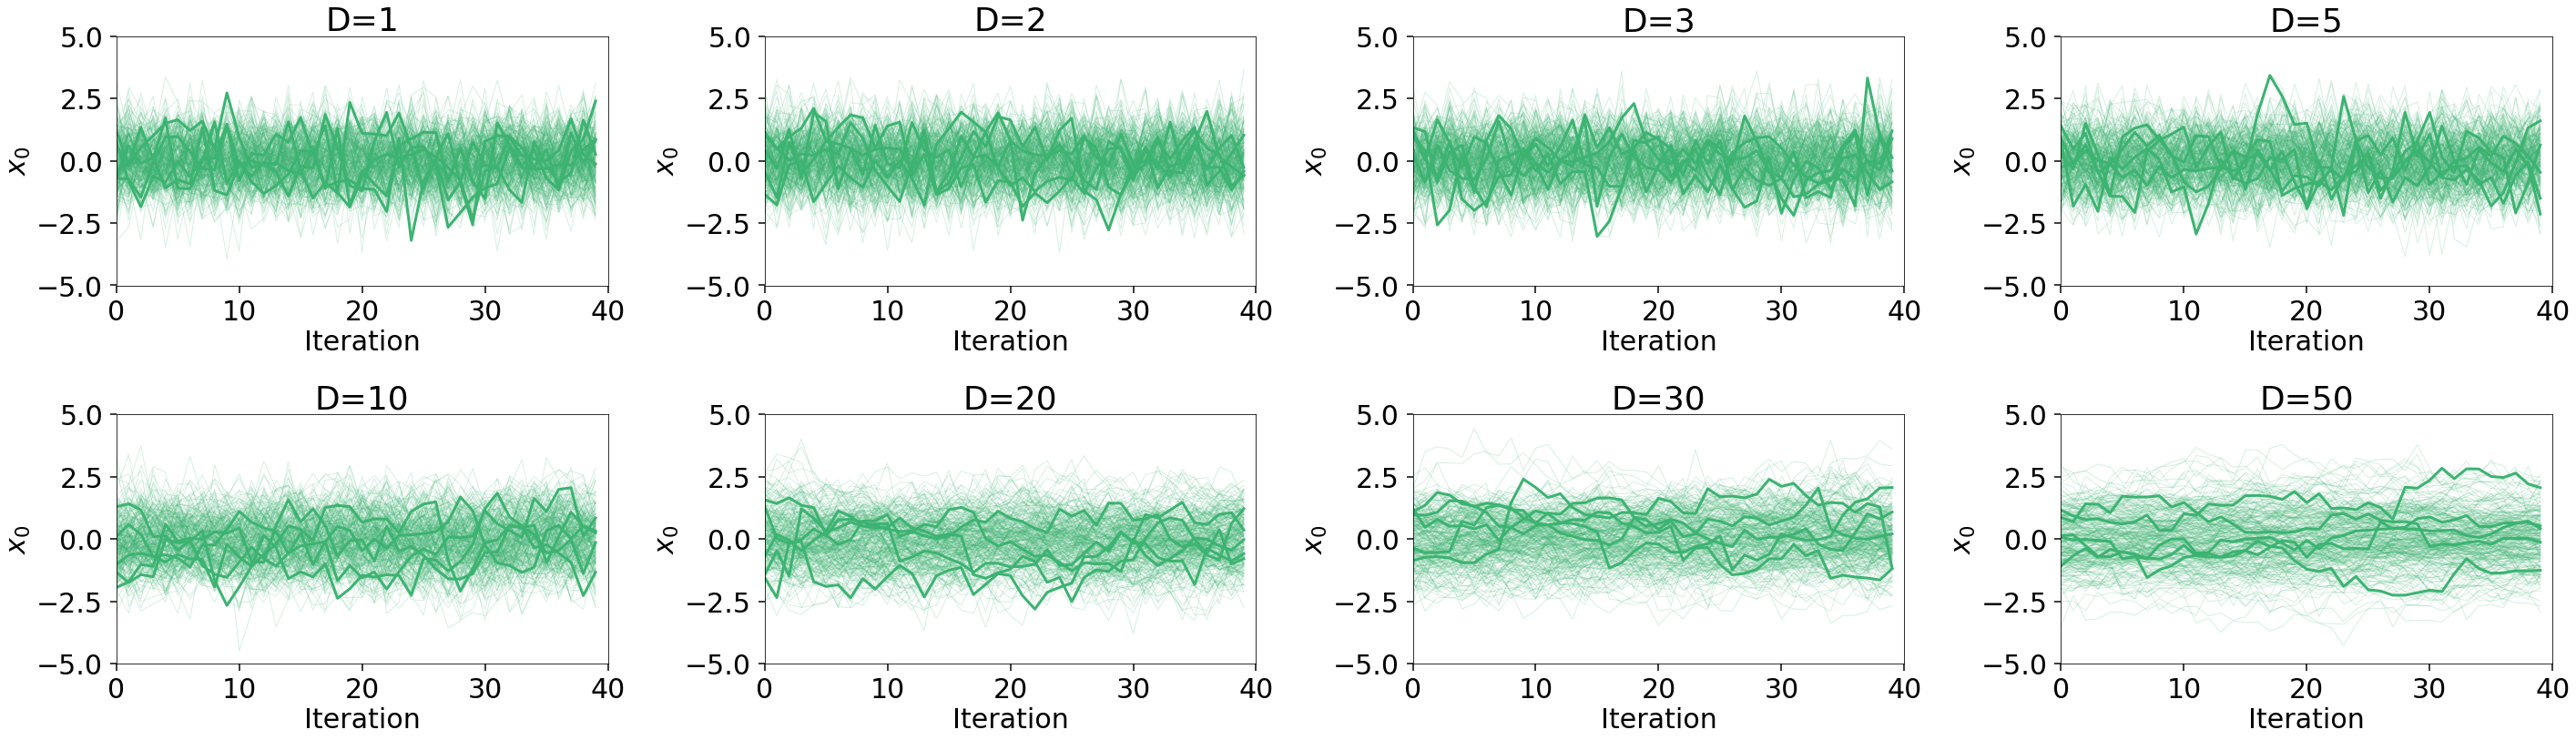

In [24]:
fig, axes = plt.subplots(2, 4, figsize=(40, 12))  # 2x4 plot
for ax, d, x in zip(axes.flatten(), dims, pos_emcee):
    
    # plot all walkers
    for i in range(Nwalkers):
        ax.plot(x[:, i, 0], color='mediumseagreen', lw=1, alpha=0.2)
        
    # highlight the behavior of a few particles
    for i in range(0, Nwalkers, 50):
        ax.plot(x[:, i, 0], color='mediumseagreen', lw=3)
    
    # prettify
    ax.set_xlim([0., Nrun])
    ax.set_xlabel('Iteration')
    ax.set_ylim([-5., 5.])
    ax.set_ylabel(u"$x_0$")
    ax.set_title('D={0}'.format(d))
fig.tight_layout()

Our traceplots confirm the intuition we derived from the typical set. They also highlight one of the pitfalls in using an ensemble-based approach: which individual particles do not actually probe the distribution very effectively, the entire *distribution* of particles actually mimics the overall distribution (by construction). This behavior can easily be masked if particles are not tracked and examined individually.

## Hamiltonian Monte Carlo

What's the solution here? Well, essentially we want three things: proposals that can (1) travel long distances (2) while remaining within the typical set (3) with "short" autocorrelation times. To accomplish this, we turn towards physical systems. 

### Hamiltonian Dynamics

We can sample from the distribution by simulating a particle "rolling" around the potential with position $\mathbf{q}$ and momentum $\mathbf{p}$ such that

$$ \mathbb{P}(\mathbf{q}, \mathbf{p}) = \frac{1}{Z} \exp\left[ -\frac{H(\mathbf{q}, \mathbf{p})}{T} \right] = \frac{1}{Z} \exp\left[ -\frac{U(\mathbf{q})}{T} \right] \exp\left[ -\frac{K(\mathbf{p})}{T} \right] $$

where the Hamiltonian $H(\mathbf{q},\mathbf{p}) = U(\mathbf{q}) + K(\mathbf{p})$ is just a sum over the potential energy $U(\mathbf{q})$ and kinetic energy $K(\mathbf{p})$ of the particle, $T$ is the temperature of the system, and $Z$ is a normalizing constant.
Letting:
our position $\mathbf{q} \equiv \boldsymbol{\Theta}$ be our parameters of interest,
our momentum $\mathbf{p} \equiv \mathbf{M} \boldsymbol{\dot{\Theta}}$ be a set of auxiliary variables tracking the change in our parameters of interest multiplied by a mass matrix $\mathbf{M}$,
our potential energy $U(\mathbf{q}) = −\ln p(\mathbf{q}) $ be the negative log-posterior,
and our kinetic energy $K(p) = \frac{1}{2} \mathbf{p}^T \mathbf{M}^{-1} \mathbf{p}$ be in a standard quadratic form,
we get

$$ P(\mathbf{q}, \mathbf{p}) \propto \exp\left[ -\frac{1}{2} \mathbf{p}^T \mathbf{M}^{-1} \mathbf{p} \right] \, p(\mathbf{q}) $$

where we have set $T=1$.

Since the Hamiltonian is conserved, the system evolves according to Hamilton's equations

$$ 
\frac{\partial \mathbf{q}}{\partial t} = \nabla_{\mathbf{p}} K = \mathbf{M}^{-1} \mathbf{p} \quad , \quad 
\frac{\partial \mathbf{p}}{\partial t} = - \nabla_{\mathbf{q}} U = \nabla_{\mathbf{q}} \ln p( \mathbf{q})
$$

and can be evolved using standard numerical integration techniques (the most commonly used are first-order "leapfrog" integrators).

To propose new points, we change the momentum (i.e. give the particle a "kick" in a random direction) by sampling from the energy distribution

$$ \mathbf{p} \sim \exp\left[ -\frac{1}{2} \mathbf{p}^T \mathbf{M}^{-1} \mathbf{p} \right] \propto \mathcal{N}(\mathbf{p} \,|\, \mathbf{0}, \mathbf{M}) $$

which is proportional to a multivariate Normal with mean $\mathbf{0}$ and covariance $\mathbf{M}$ (often taken to be the identity matrix or the Hessian around the MAP).

Next, we propose a new state using Hamiltonian dynamics. Starting at $(\mathbf{q}, \mathbf{p})$, we evolve the system for $L$ steps of size $\epsilon$. The momentum variables are then negated (although this rarely needs to be done in practice), leaving us with the proposed state $(\mathbf{q}^\prime, \mathbf{p}^\prime)$.

Finally, we perform a Metropolis update, accepting the proposed state with probability

$$ \min \left\lbrace 1, \, \exp\left[-H(\mathbf{q}^\prime, \mathbf{p}^\prime) + H(\mathbf{q}, \mathbf{p}) \right] \right\rbrace = \min \left\lbrace 1, \, \exp\left[-U(\mathbf{q}^\prime) + U(\mathbf{q}) - K(\mathbf{p}^\prime) + K(\mathbf{p}) \right] \right\rbrace $$

Since energy is conserved (up to numerical integration error), we very often satisfy this acceptance criteria.

## "Riding the Wave" with HMC

By construction, our particle will spend the majority of its time rolling around in the typical set allowing us to gather efficient samples by taking "snapshots" in time. Since energy is conserved (up to numerical integration), the acceptance fraction will also tend to be close to 1, leading to much more efficient proposals. And since the particle is allowed to have trajectories through the distribution, it can travel long distances within the typical set, leading to more independent samples compared with standard MH proposals.

Let's see how this works in practice using a simple HMC sampler.

In [25]:
# initialize our HMC sampler

def gradlogp(x):
    """Gradient of the log-posterior."""
    
    return -x

def leapfrog(L, epsilon, Minv, q, p, gradfn):
    """Leapfrog (second-order) integrator."""
    
    q_t, p_t = q.copy(), p.copy()  # initialize (position, momentum)
    p_t = p_t + 0.5 * epsilon * gradfn(q_t)  # initial momentum half-step
    q_t = q_t + epsilon * np.dot(Minv, p_t)  # initial position step
    for t in xrange(L):
        p_t = p_t + epsilon * gradfn(q_t)  # momentum step
        q_t = q_t + epsilon * np.dot(Minv, p_t)  # position step
    p_t = p_t + 0.5 * epsilon * gradfn(q_t)  # final momentum half-step
    
    return q_t, -p_t

def hmc_tprob(lnp, p, lnp_new, p_new, Minv):
    """HMC transition probability."""
    
    H = -lnp + 0.5 * np.dot(p.T, np.dot(Minv, p))
    H_new = -lnp_new + 0.5 * np.dot(p_new.T, np.dot(Minv, p_new))
    prob = np.exp(-H_new + H)
    
    return prob

def hmc_update(theta, lnp, L, epsilon, M, Minv, lnprobfn, gradfn):
    """Update the position of the chain using HMC."""
    
    p = np.random.multivariate_normal(np.zeros_like(theta), M)  # sample momentum 
    q, lnp = theta.copy(), lnp  # initial (position, momentum, lnP)
    q_out, p_out, = leapfrog(L, epsilon, Minv, q, p, gradfn)  # final (position, momentum)
    lnp_out = lnprobfn(q_out)  # final lnP
    tprob = hmc_tprob(lnp, p, lnp_out, p_out, Minv)  # transition probability
    
    # accept/reject
    if np.random.rand() < tprob:
        return q_out, lnp_out
    else:
        return q, lnp

def hmc_sampler(theta, N, L, epsilon, M, Minv, lnprobfn, gradfn, 
                stochastic=True, fvar=0.2, thin=1):
    """Our HMC-style sampler."""
    
    q = theta.copy()  # position 
    lnp = lnprobfn(q)  # lnP
    q_chain, lnp_chain = [], []  # intialize chain
    L_init, epsilon_init = np.copy(L), epsilon  # initialize integration parameters
    
    n, count = 0, 0
    while n < N:
        if n % 1000 == 0 and count == 0: 
            sys.stderr.write(str(n)+' ')
        if stochastic:  # let L and epsilon slightly vary
            L = np.random.randint(L_init * (1 - fvar), L_init * (1 + fvar) + 1e-10)
            epsilon = np.random.uniform(epsilon_init * (1 - fvar), epsilon_init * (1 + fvar))
        q, lnp = hmc_update(q, lnp, L, epsilon, M, Minv, lnprobfn, gradfn)  # HMC update
        if (count + 1) % thin == 0:
            q_chain.append(q)
            lnp_chain.append(lnp)
            count = 0
            n += 1
        else:
            count += 1
        
    return np.array(q_chain), np.array(lnp_chain)

In [26]:
L, epsilon = 50, 0.15  # path length, step-size
Niter = 10000  # number of samples

pos_hmc = []
for d in dims:
    pos_init = np.random.randn(d)  # initial position
    mass = np.identity(d)  # mass matrix
    mass_inv = np.linalg.inv(mass)  # inverse mass matrix
    
    # sample!
    sys.stderr.write('D={0}: '.format(d))
    pos_chain_hmc, lnp_chain_hmc = hmc_sampler(pos_init, Niter, L, epsilon, 
                                               mass, mass_inv, logp, gradlogp, thin=10)
    sys.stderr.write('\n')
    pos_hmc.append(pos_chain_hmc)

D=1: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 
D=2: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 
D=3: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 
D=5: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 
D=10: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 
D=20: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 
D=30: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 
D=50: 0 1000 2000 3000 4000 5000 6000 7000 8000 9000 


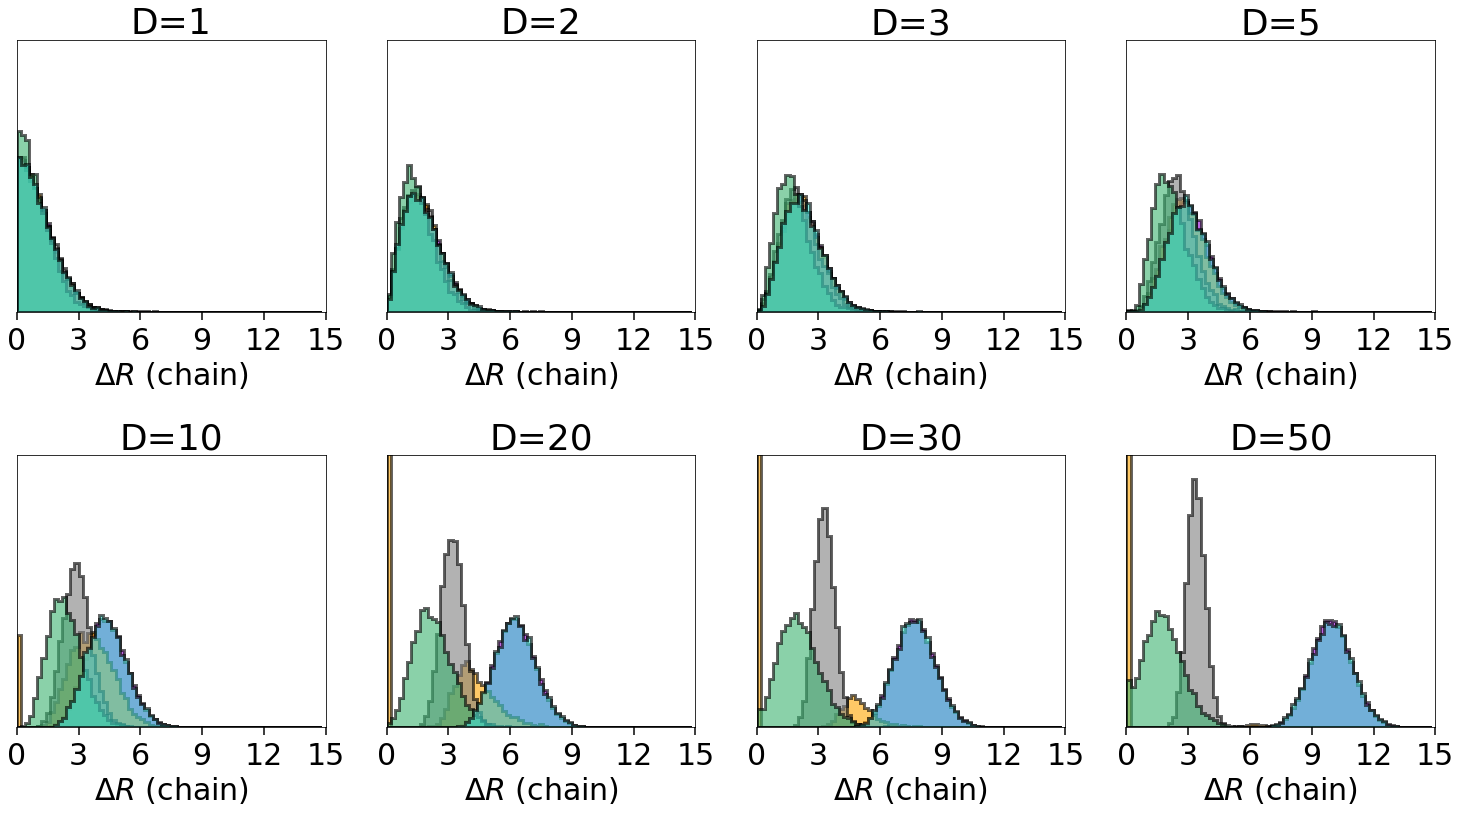

In [27]:
# chain updates

fig, axes = plt.subplots(2, 4, figsize=(21, 12))  # 2x4 plot
for ax, d, pmh, pamh, pemcee, phmc in zip(axes.flatten(), dims, pos_mh, 
                                          pos_amh, pos_emcee, pos_hmc):
    
    # ideal case
    x = np.random.randn(Nmc, d)
    dx = np.sqrt(np.sum((x[1:] - x[:-1])**2, axis=1))
    __ = ax.hist(dx, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='darkviolet', normed=True)
    
    # MH case
    dx_mh = np.sqrt(np.sum((pmh[1:] - pmh[:-1])**2, axis=1))
    __ = ax.hist(dx_mh, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='orange', normed=True)
    
    # AMH case
    dx_amh = np.sqrt(np.sum((pamh[1:] - pamh[:-1])**2, axis=1))
    __ = ax.hist(dx_amh, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='gray', normed=True)
    
    # emcee case
    dx_emcee = np.sqrt(np.sum((pemcee[1:] - pemcee[:-1])**2, axis=2)).flatten()
    __ = ax.hist(dx_emcee, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='mediumseagreen', normed=True)
    
    # HMC case
    dx_hmc = np.sqrt(np.sum((phmc[1:] - phmc[:-1])**2, axis=1))
    __ = ax.hist(dx_hmc, bins=r2[::200], alpha=0.6, 
                 histtype='stepfilled', edgecolor='black',
                 lw=3, color='turquoise', normed=True)
    
    # prettify
    ax.set_xlim([0., 15.])
    ax.set_xticks(np.arange(0, 15+1, 3))
    ax.set_xlabel(u'$\Delta R$ (chain)')
    ax.set_yticks([])
    ax.set_ylim([0., 1.])
    ax.set_title('D={0}'.format(d))
fig.tight_layout()

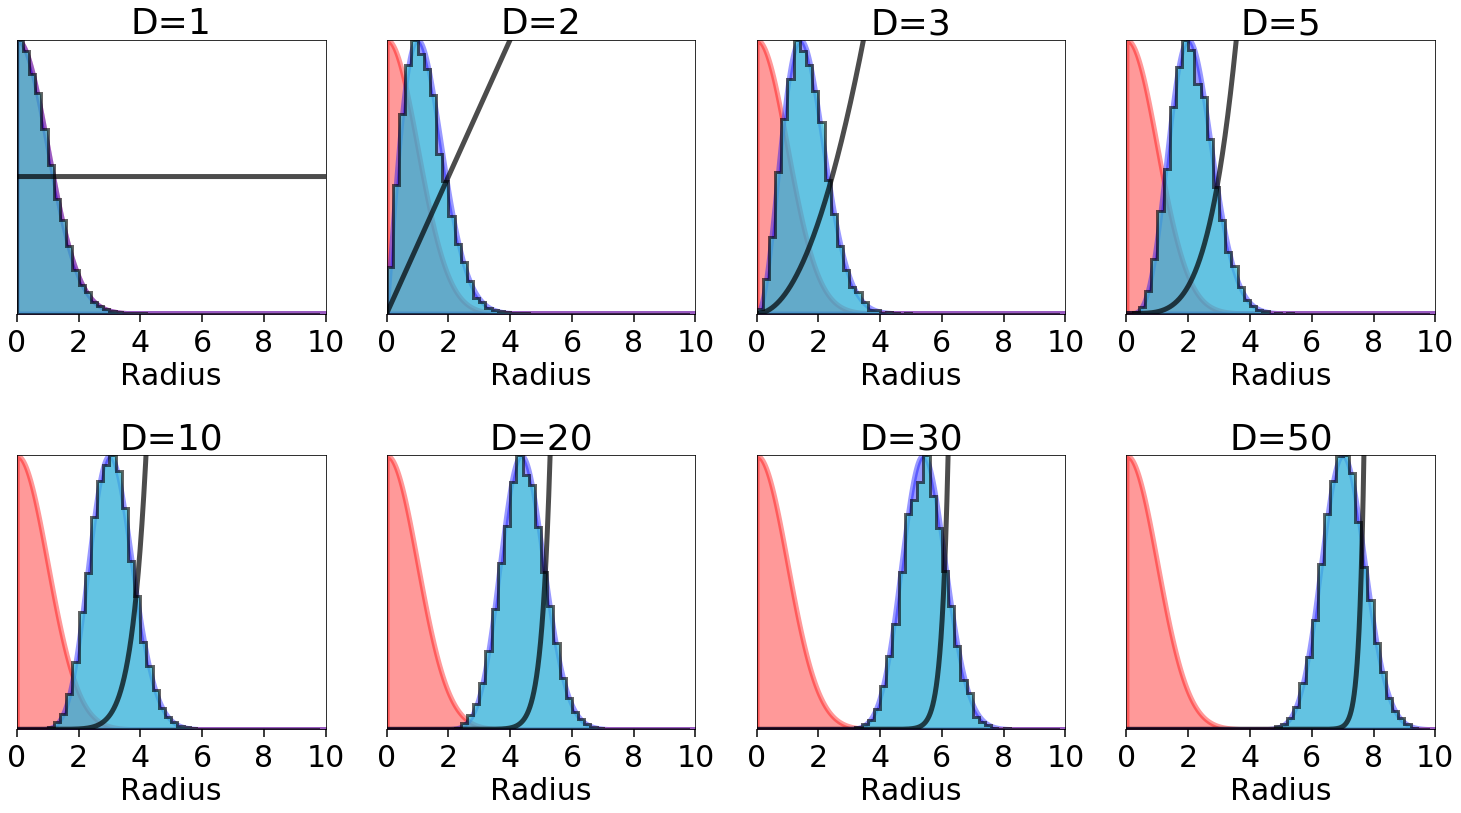

In [28]:
# distance from MAP

fig, axes = plt.subplots(2, 4, figsize=(21, 12))  # 2x4 plot
for ax, dvol, d, x in zip(axes.flatten(), dv, dims, pos_hmc):
    ax.fill_between(r, y, lw=5, color='red', alpha=0.4)  # posterior
    ts = dvol * y / max(dvol * y)
    xmax = ts.argmax()
    ax.fill_between(r, ts, lw=5, color='blue', alpha=0.4)  # typical set
    ax.plot(r, dvol / dvol[xmax] / d / 2., lw=5, color='black', alpha=0.7)  # dvol
    
    # prettify
    ax.set_xlim([0., 10.])
    ax.set_ylim([0., 1.])
    ax.set_xticks(np.arange(0, 10+1, 2))
    ax.set_xlabel('Radius')
    ax.set_yticks([])
    ax.set_title('D={0}'.format(d))
    
    # add HMC samples
    radius = np.sqrt(np.sum(x**2, axis=1))
    N, __ = np.histogram(radius, bins=r[::200])
    __ = ax.hist(radius, bins=r[::200], alpha=0.6, lw=3, color='turquoise', 
                 histtype='stepfilled', edgecolor='black',
                 weights=np.ones(len(radius)) * 1. / max(N))
    
fig.tight_layout()

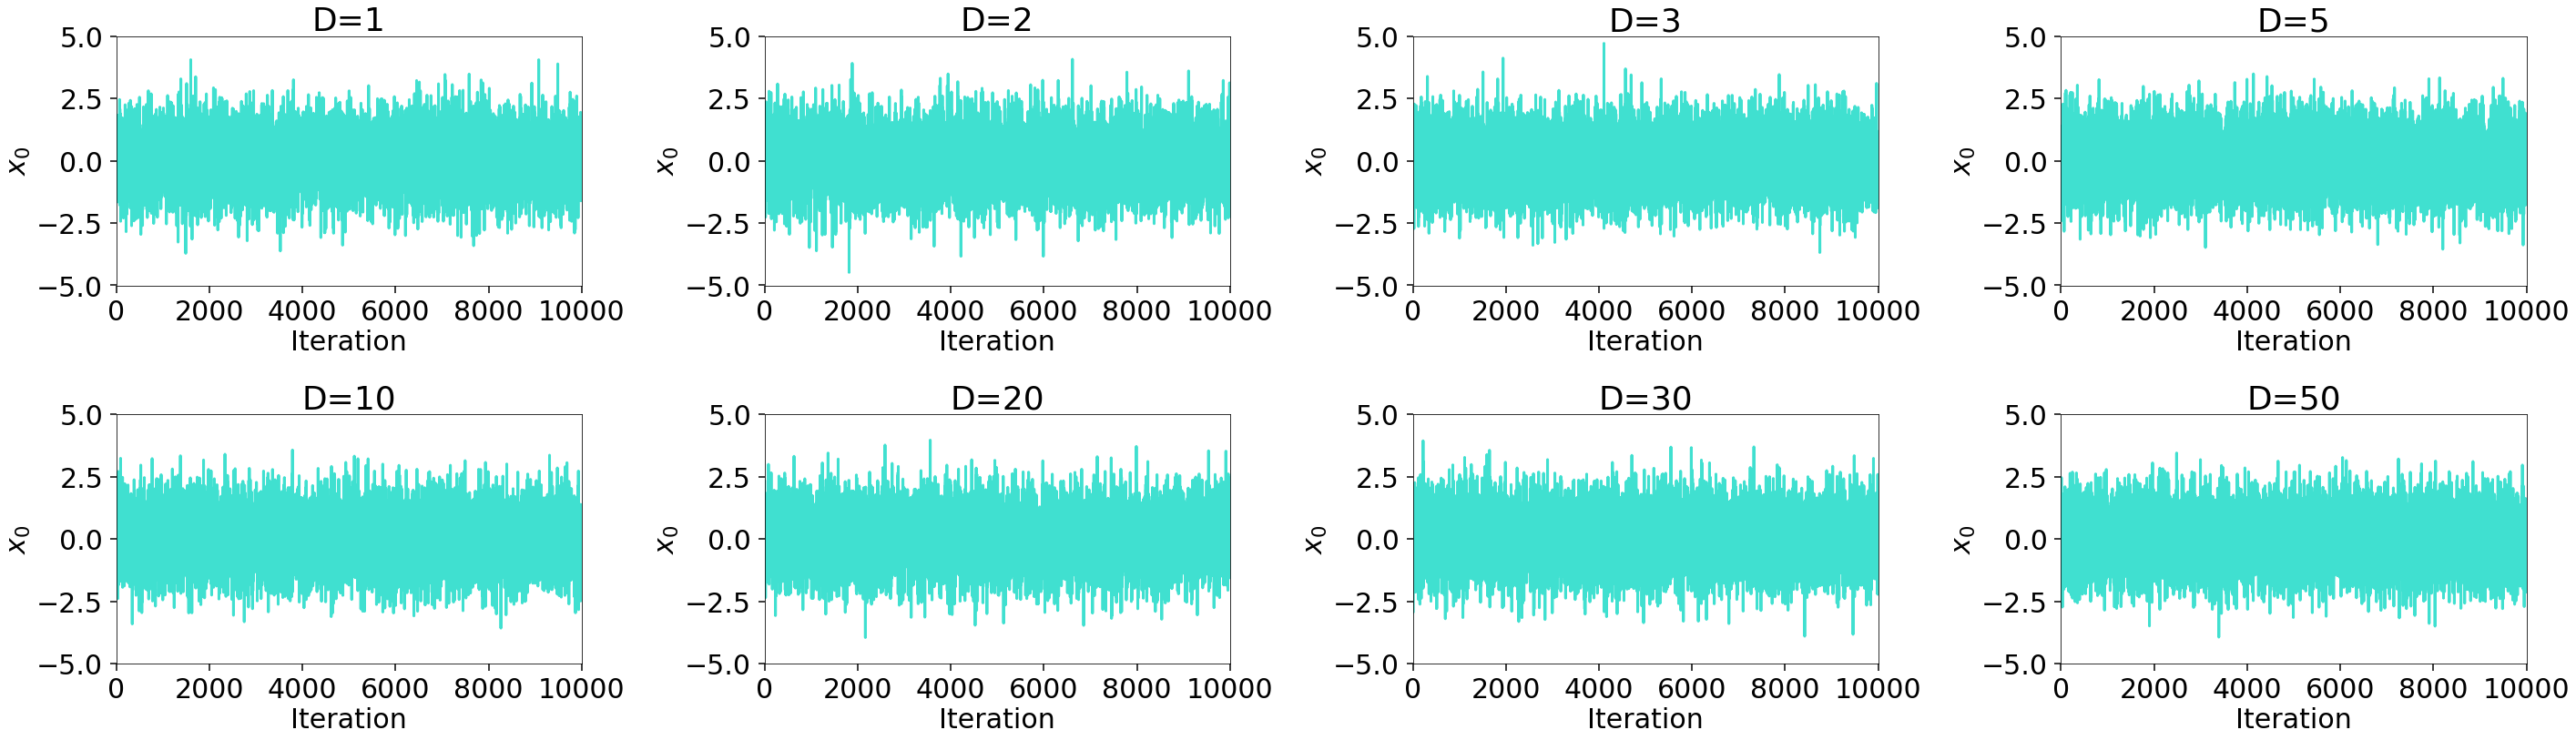

In [29]:
# trace

fig, axes = plt.subplots(2, 4, figsize=(40, 12))  # 2x4 plot
for ax, d, x in zip(axes.flatten(), dims, pos_hmc):
    
    ax.plot(x[:,0], color='turquoise', lw=3)

    # prettify
    ax.set_xlim([0., Niter])
    ax.set_xlabel('Iteration')
    ax.set_ylim([-5., 5.])
    ax.set_ylabel(u"$x_0$")
    ax.set_title('D={0}'.format(d))
fig.tight_layout()

Nailed it! Our samples are fully consistent with being independent draws from the posterior.

## Summary

Whenever you're trying to estimate posteriors with sampling techniques (especially MCMC), always keep typical sets (i.e. that posterior density is not overall probability) in mind. More generally, remember that it's easy to be fooled by "intuition", especially since we don't have a lot of experience with high-dimensional volumes and pathological functions in our everyday lives!